# Projet_P7 : Effectuez une prédiction de revenus

In [1]:
from functions_P7 import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
from scipy.stats import pearsonr
%matplotlib inline
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from math import pi

# Mission 1

## Téléchargement des données

In [2]:
# on choisit la table de travail (choix 1 : table_imputations_moyenne, choix 2 : table_imputations_mediane)
url  = 'INPUTS_FORMATION/P7_data.csv'
url2 = 'INPUTS_FORMATION/P7_Metadata_Country_GINI.csv'
url3 = 'INPUTS_FORMATION/P7_GINI.csv'
url4 = 'INPUTS_FORMATION/P7_population_from_FAO.csv' 

table   = pd.read_csv(url, sep=',',encoding='utf-8')

country = pd.read_csv(url2, sep=',')
country.rename(columns={'Country Code':'Country_Code'}, inplace=True)

GINI    = pd.read_csv(url3, sep=',')
GINI.rename(columns={'Country Code':'Country_Code'}, inplace=True)

POP     = pd.read_csv(url4, sep=',')
POP.rename(columns={'Code zone (ISO3)':'Country_Code','Année':'year_survey','Valeur':'population'}, inplace=True)
POP = POP[['Country_Code','year_survey','population']]
POP['population']=POP['population']*1e3

table['income'] = table['income'].str.replace(',', '.')
table['gdpppp'] = table['gdpppp'].str.replace(',','.')
table['gdpppp'] = pd.to_numeric(table['gdpppp']).round(1)
table['income'] = pd.to_numeric(table['income']).round(0)
table.rename(columns={'country':'Country_Code'}, inplace=True)
# table.head()

In [3]:
# prof = ProfileReport(table)
# prof.to_file(output_file='rapport_table.html')

## Data cleaning

In [4]:
table.describe(include='all')

Country_Code   year_survey      quantile  nb_quantiles         income  \
count         11599  11599.000000  11599.000000       11599.0   11599.000000   
unique          116           NaN           NaN           NaN            NaN   
top             ALB           NaN           NaN           NaN            NaN   
freq            100           NaN           NaN           NaN            NaN   
mean            NaN   2007.982757     50.500819         100.0    6069.229416   
std             NaN      0.909633     28.868424           0.0    9414.188204   
min             NaN   2004.000000      1.000000         100.0      17.000000   
25%             NaN   2008.000000     25.500000         100.0     901.000000   
50%             NaN   2008.000000     51.000000         100.0    2403.000000   
75%             NaN   2008.000000     75.500000         100.0    7515.500000   
max             NaN   2011.000000    100.000000         100.0  176929.000000   

              gdpppp  
count   1.139900e+04  
unique           NaN  
top              NaN  
freq             NaN  
mean    5.022128e+04  
std     4.000688e+05  
min     3.032000e+02  
25%     2.576000e+03  
50%     7.560000e+03  
75%     1.877300e+04  
max     4.300332e+06

**<div class="alert-success">
<font color='k'> Cleaning [gdpppp correction : FJI]
</font></div>**

                 gdpppp
Country_Code           
FJI           4300332.0


Text(0.5, 0, '')

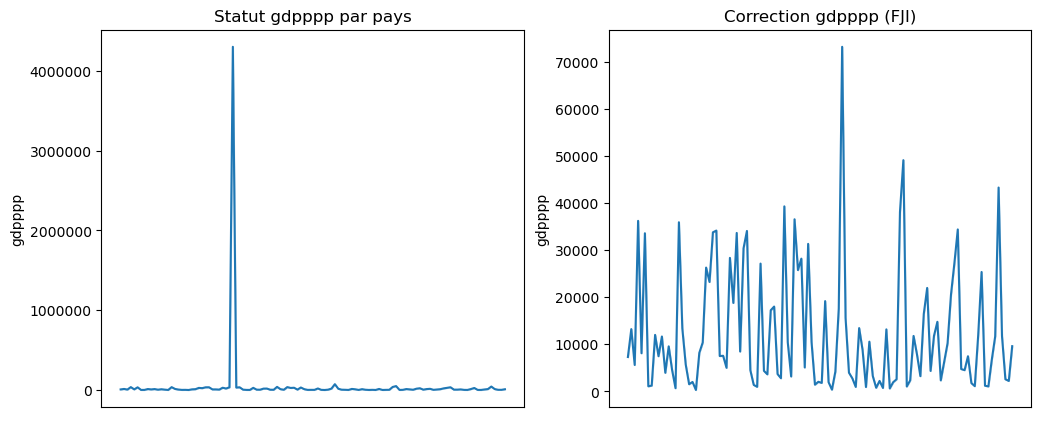

In [5]:
visu_gdpppp = table.groupby(['Country_Code']).agg({'gdpppp':'mean'})
exceed_value = visu_gdpppp[visu_gdpppp['gdpppp']>1e5]
print(exceed_value) 

plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.subplot(1, 2, 1)
sns.lineplot(data=table, x="Country_Code", y="gdpppp")
plt.title('Statut gdpppp par pays')
plt.xticks([], [])
plt.xlabel("")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.subplot(1, 2, 2)
table.loc[table['Country_Code'] == "FJI", 'gdpppp'] = 8464 #https://knoema.com/atlas/Fiji/GDP-per-capita-based-on-PPP
sns.lineplot(data=table, x="Country_Code", y="gdpppp")   
plt.title('Correction gdpppp (FJI)')
plt.xticks([], [])
plt.xlabel("")

**<div class="alert-success">
<font color='k'> Cleaning [rename, drop]
</font></div>**

In [6]:
POP['Country_Code'].unique()

array(['AFG', 'ZAF', 'ALB', 'DZA', 'DEU', 'AND', 'AGO', 'AIA', 'ATG',
       'ANT', 'SAU', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS',
       'BHR', 'BGD', 'BRB', 'BLR', 'BEL', '15', 'BLZ', 'BEN', 'BMU',
       'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BRA', 'BRN', 'BGR', 'BFA',
       'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CHL', 'HKG', 'MAC', '41',
       'TWN', 'CYP', 'COL', 'COM', 'COG', 'CRI', 'CIV', 'HRV', 'CUB',
       'CUW', 'DNK', 'DJI', 'DMA', 'EGY', 'SLV', 'ARE', 'ECU', 'ERI',
       'ESP', 'EST', 'SWZ', 'USA', 'ETH', '62', 'RUS', 'FJI', 'FIN',
       'FRA', 'GAB', 'GMB', 'GEO', 'GHA', 'GIB', 'GRC', 'GRD', 'GRL',
       'GLP', 'GUM', 'GTM', 'GIN', 'GNQ', 'GNB', 'GUY', 'GUF', 'HTI',
       'HND', 'HUN', 'IMN', 'CHA', 'CYM', 'COK', 'FLK', 'FRO', 'MNP',
       'MHL', 'SLB', 'TCA', 'VIR', 'VGB', 'WLF', 'IND', 'IDN', 'IRN',
       'IRQ', 'IRL', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ',
       'KEN', 'KGZ', 'KIR', 'KWT', 'LSO', 'LVA', 'LBN', 'LBR', 'LBY',
       'LIE', 'LTU', 'L

In [7]:
POP['Country_Code'] = POP['Country_Code'].replace('41' ,'CHN')
POP['Country_Code'] = POP['Country_Code'].replace('62' ,'ETH')
POP.drop(POP.loc[POP['Country_Code']== '15' ].index, inplace=True) # BEL-LUX aggregate
POP.drop(POP.loc[POP['Country_Code']== '206' ].index, inplace=True) # ex-Soudan
POP.drop(POP.loc[POP['Country_Code']== '248' ].index, inplace=True) # RFS de Yougoslavie
POP.drop(POP.loc[POP['Country_Code']== '51' ].index, inplace=True) # Tchécoslovaquie => Kosovo
POP.drop(POP.loc[POP['Country_Code']== '164' ].index, inplace=True) # Territoire des Îles du Pacifique
POP.drop(POP.loc[POP['Country_Code']== '228' ].index, inplace=True) # URSS (data until 1991)

**<div class="alert-success">
<font color='k'> Cleaning [Kosovo population]
</font></div>**

In [8]:
# création/imputation population KOSOVO "XKX"
pop_Kosovo = 1794984 #http://www.geoba.se/country.php?cc=XK&year=2008
new_row = {'population':pop_Kosovo,'Country_Code':'XKX','year_survey':2008}
POP = POP.append(new_row, ignore_index=True)

In [9]:
# jointure données pays au df
table = pd.merge(table, country, how="left", on="Country_Code")
table.drop(columns=['nb_quantiles','SpecialNotes','Unnamed: 5'], inplace=True)

# jointure données GINI au df
table = pd.merge(table, GINI, how="left", on="Country_Code")
table.drop(columns=['Country Name','Indicator Code','Indicator Name','Unnamed: 65'], inplace=True)

# jointure données population au df
table = pd.merge(table, POP, how="left", on=['Country_Code','year_survey'])

# table.to_csv("OUTPUTS_FORMATION/P7_table.csv", index = False)

**<div class="alert-success">
<font color='k'> Cleaning [état des lieux]
</font></div>**

<AxesSubplot:>

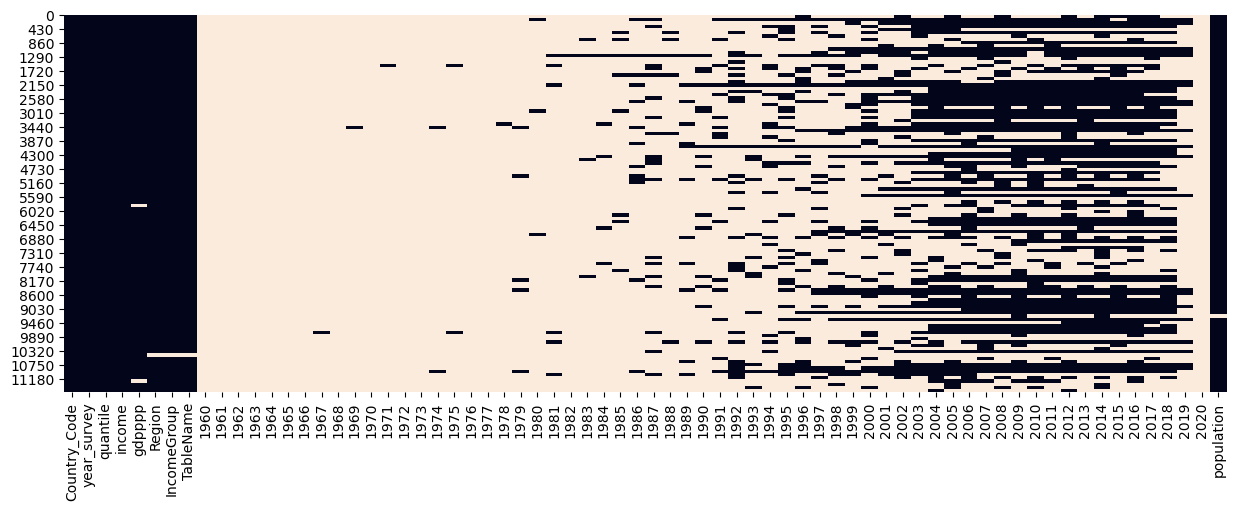

In [10]:
plt.figure(figsize=(15,5))
sns.heatmap(table.isna(), cbar=False)

**<div class="alert-success">
<font color='k'> Cleaning [Soudan population]
</font></div>**

In [11]:
# iputation population SOUDAN "SDN" en 2009 ...google
pop_Soudan = 33780000
table['population'] = table['population'].replace(np.nan ,pop_Soudan)

**<div class="alert-success">
<font color='k'> Cleaning [Taïwan informations]
</font></div>**

In [12]:
# renseigner informations pour Taïwan : East Asia & Pacific | High income | Taiwan SAR, China
table[table['TableName'].isnull()]
table.loc[table['Country_Code'] == "TWN", 'Region'] = 'East Asia & Pacific'
table.loc[table['Country_Code'] == "TWN", 'IncomeGroup'] = 'High income'
table.loc[table['Country_Code'] == "TWN", 'TableName'] = 'Taiwan SAR China'

**<div class="alert-success">
<font color='k'> Cleaning [gdpppp : Imputations for Palestine & Kosovo]
</font></div>**

In [13]:
table.loc[table['Country_Code'] == "PSE", 'gdpppp'] = 3544 #PSE (Palestine) https://www.theglobaleconomy.com/palestine/gdp_per_capita_ppp/ 
table.loc[table['Country_Code'] == "XKX", 'gdpppp'] = 7366 #XKX (Kosovo) https://knoema.fr/IMFWEO2021Apr/imf-world-economic-outlook-weo-database-april-2021

**<div class="alert-success">
<font color='k'> Cleaning [état des lieux final]
</font></div>**

<AxesSubplot:>

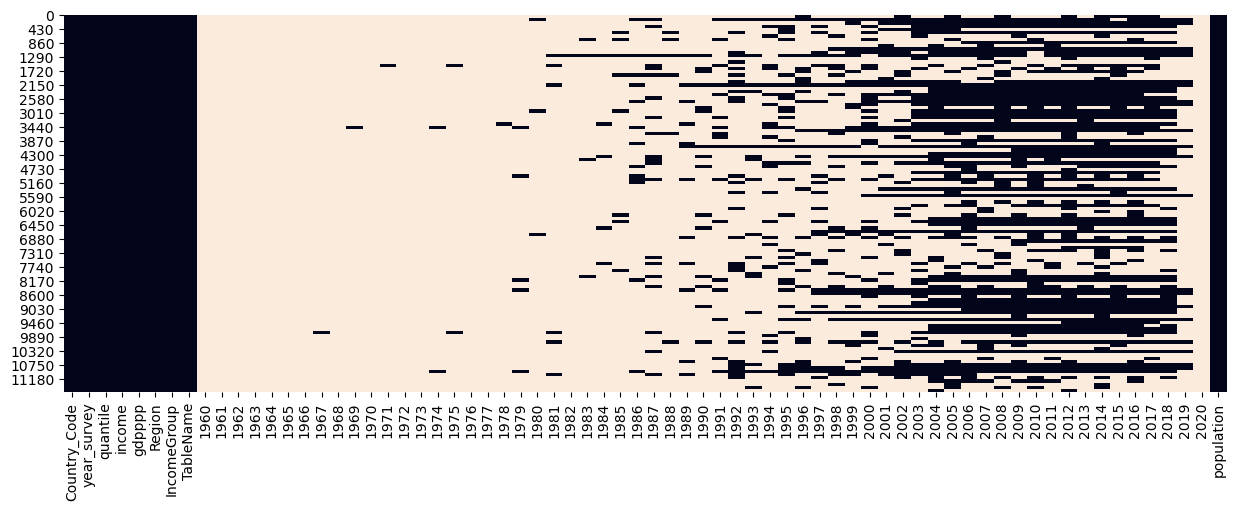

In [14]:
plt.figure(figsize=(15,5))
sns.heatmap(table.isna(), cbar=False)

## Année des données

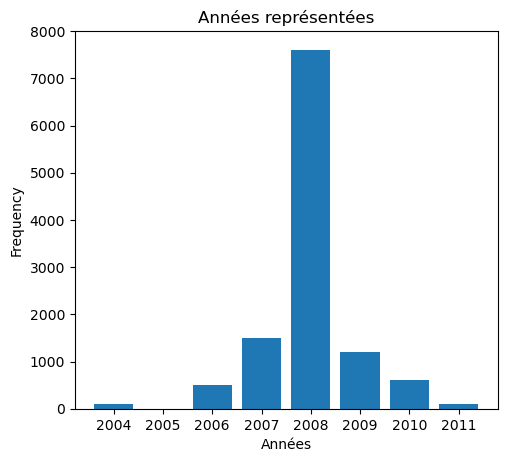

Année des données : 
2008    7599
2007    1500
2009    1200
2010     600
2006     500
2011     100
2004     100
Name: year_survey, dtype: int64


In [15]:
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.subplot(1, 2, 1)
x = table['year_survey'].sort_values()
labels, counts = np.unique(x, return_counts=True)
plt.bar(labels, counts, align='center')
# plt.gca().set_xticks(labels)
# plt.grid(True)
plt.xlabel('Années',fontsize=10)
plt.title('Années représentées')
plt.ylim(0,8e3)
plt.ylabel("Frequency",fontsize=10)
plt.savefig('OUTPUTS_FORMATION/P7_années_data.jpg',dpi=300)
plt.show()
print('\x1b[6;31;40m' + 'Année des données : \n'+str(table['year_survey'].value_counts())+'\x1b[0m')

## Nombre de pays étudiés

In [16]:
print('\x1b[6;31;40m' + 'Nb pays représentés : '+str(table['TableName'].unique().size)+'\x1b[0m')

Nb pays représentés : 116


## Représentativité

In [17]:
pop_Mondiale = table.groupby(['Country_Code']).agg({'population':'mean'}).sum()

for i, row in table.iterrows():
    table.loc[i,'population_vs_Mde_in_%'] = round(100*(table.iloc[i,table.columns.get_loc('population')]/pop_Mondiale[0]),2)

print('\x1b[6;31;40m'+str(round(100*(table['population'].sum()/100)/7e9,1))+"% de la population mondiale"+'\x1b[0m')

88.8% de la population mondiale


## Type de quantiles (quartiles, déciles, etc.) ?

<div class="alert alert-info" role="alert">
<font color='green'>Il sagit de CENTILES.
    
Les quantiles séparent une population en n classes d’égal effectif, permettent de situer très rapidement un sujet au sein d'une population parente.</font></div>

Définition : En statistique descriptive, un centile est chacune des 99 valeurs qui divisent les données triées en 100 parts égales, de sorte que chaque partie représente 1/100 de l'échantillon de population.

Exemple: Si on regarde la répartition des revenus de la population, on pourra par exemple calculer « le revenu moyen du dernier décile (ou des dix derniers centiles) », soit le revenu moyen des 10 % de gens qui gagnent le plus, et « le seuil de revenu correspondant au 90e centile, au 95e centile », soit le revenu que gagne la personne la moins riche parmi les 10 % ou les 5 % des plus riches. Le 50e centile représente quant à lui le salaire médian.

Formule de calcul du rang : R100(X) = 100(Di+0.5De)/n , arrondir à l’entier supérieur
- R100(X) : rang centile R100(X) d’une donnée X d’une distribution comprenant n données (correspond au % de données < ou = à la donnée X)
- Di : données inférieures à X
- De : données égales à X



## Définition $PPP et pertinence

OCDE (Organisation de coopération et de développement économiques) définit les Parités de Pouvoir d'Achat (PPP for Purchasing Power Parities) comme : 

<div class="alert alert-info" role="alert">
<font color='green'>Les TAUX de CONVERSION monétaire qui EGALISENT les POUVOIRS D'ACHAT des différentes monnaies</font></div>

(une somme d'argent donnée, convertie au moyen des PPA en différentes monnaies, permettra d'acheter le même panier de biens et de services dans tous les pays en question et ainsi permettra une comparaison de pays à pays).

In [18]:
table_init_0 = table.copy()
table_init = table.copy()

**<div class="alert-success">
<font color='k'> Cleaning [centile imputation for LTU]
</font></div>**

In [19]:
df_rech_quantile = table_init_0.copy()
# Compte des quantiles
df_rech_quantile_tst = df_rech_quantile.groupby(['Country_Code']).agg({'quantile':'count'})
print(df_rech_quantile_tst['quantile'].value_counts())
# affichage des pays où des centiles sont manquants
df_rech_quantile_tst.loc[df_rech_quantile_tst['quantile'] == 99]

100    115
99       1
Name: quantile, dtype: int64


quantile
Country_Code          
LTU                 99

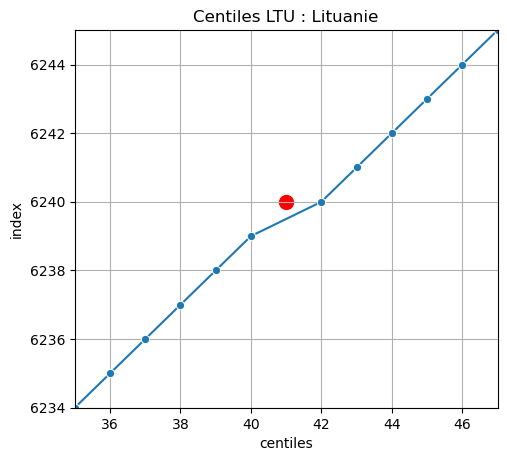

In [20]:
df_rech_quantile_bis = table_init_0.copy()
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.subplot(1, 2, 1)
df_rech_quantile_bis = df_rech_quantile_bis[df_rech_quantile_bis['Country_Code']=="LTU"]
sns.lineplot(data=df_rech_quantile_bis, x='quantile', y=df_rech_quantile_bis.index,marker="o")
plt.axis([35, 47, 6234, 6245])
plt.grid()
plt.title("Centiles LTU : Lituanie")
plt.ylabel('index')
plt.xlabel('centiles')
plt.scatter(41,6240,marker="o",c='r',s=100)

In [21]:
# on stocke les valeurs des 2 lignes "encadrantes"
inc_inf = df_rech_quantile_bis.loc[df_rech_quantile_bis['quantile'] == 40, 'income'].values[0]
inc_sup = df_rech_quantile_bis.loc[df_rech_quantile_bis['quantile'] == 42, 'income'].values[0]
gdp_inf = df_rech_quantile_bis.loc[df_rech_quantile_bis['quantile'] == 40, 'gdpppp'].values[0]
gdp_sup = df_rech_quantile_bis.loc[df_rech_quantile_bis['quantile'] == 42, 'gdpppp'].values[0]

# on isole la ligne correspondant au quantile 40 comme base de départ (modification + ajout)
line_duplicated = pd.DataFrame(pd.np.repeat(df_rech_quantile_bis[39:40].values,1,axis=0),columns=df_rech_quantile_bis.columns)
line_duplicated

Country_Code year_survey quantile  income   gdpppp                 Region  \
0          LTU        2008       40  4868.0  17571.0  Europe & Central Asia   

   IncomeGroup  TableName 1960 1961  ...  2013  2014  2015  2016  2017  2018  \
0  High income  Lithuania  NaN  NaN  ...  35.3  37.7  37.4  38.4  37.3  35.7   

  2019 2020 population population_vs_Mde_in_%  
0  NaN  NaN  3212865.0                   0.05  

[1 rows x 71 columns]

In [22]:
# on corrige les données pr la nouvelle ligne par interpolation linéaire
line_duplicated.loc[line_duplicated['quantile'] == 40, 'quantile'] = 41
line_duplicated.loc[line_duplicated['income'] == 4868, 'income']   = (inc_inf+inc_sup)/2
line_duplicated.loc[line_duplicated['gdpppp'] == 17571, 'gdpppp']  = (gdp_inf+gdp_sup)/2
# append row to the dataframe
df_rech_quantile_bis = df_rech_quantile_bis.append(line_duplicated, ignore_index=False)
# sort by quantile
df_rech_quantile_bis = df_rech_quantile_bis.sort_values(['quantile'], ascending=1)
# reset index
df_rech_quantile_bis = df_rech_quantile_bis.reset_index()
# add 6200 to each index
df_rech_quantile_bis.index = df_rech_quantile_bis.index + 6200
# visualisation de la ligne ajoutée
df_rech_quantile_bis[39:42]

index Country_Code year_survey quantile  income   gdpppp  \
6239   6239          LTU        2008       40  4868.0  17571.0   
6240      0          LTU        2008       41  4882.0  17571.0   
6241   6240          LTU        2008       42  4896.0  17571.0   

                     Region  IncomeGroup  TableName 1960  ...  2013  2014  \
6239  Europe & Central Asia  High income  Lithuania  NaN  ...  35.3  37.7   
6240  Europe & Central Asia  High income  Lithuania  NaN  ...  35.3  37.7   
6241  Europe & Central Asia  High income  Lithuania  NaN  ...  35.3  37.7   

      2015  2016  2017  2018 2019 2020 population population_vs_Mde_in_%  
6239  37.4  38.4  37.3  35.7  NaN  NaN  3212865.0                   0.05  
6240  37.4  38.4  37.3  35.7  NaN  NaN  3212865.0                   0.05  
6241  37.4  38.4  37.3  35.7  NaN  NaN  3212865.0                   0.05  

[3 rows x 72 columns]

In [23]:
# conversion numérique
df_rech_quantile_bis[['index', 'year_survey', 'quantile', 'income', 'gdpppp','1960', '1961', '1962', '1963','1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972','1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981','1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990','1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999','2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008','2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017','2018', '2019', '2020', 'population', 'population_vs_Mde_in_%']] = df_rech_quantile_bis[['index', 'year_survey', 'quantile', 'income', 'gdpppp','1960', '1961', '1962', '1963','1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972','1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981','1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990','1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999','2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008','2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017','2018', '2019', '2020', 'population', 'population_vs_Mde_in_%'
                    ]].apply(pd.to_numeric)

In [24]:
df_rech_quantile_ter = table_init_0.copy()
# on supprime les données initiales LTU
df_rech_quantile_ter.drop(df_rech_quantile_ter.loc[df_rech_quantile_ter['Country_Code']=="LTU" ].index, inplace=True)
# on concatène [df-LTU] à [df_LTU_modifié]
df_rech_quantile_quar = df_rech_quantile_ter.append(df_rech_quantile_bis, ignore_index=False)
# on réordonne par index
df_rech_quantile_quar.sort_index(inplace=True)

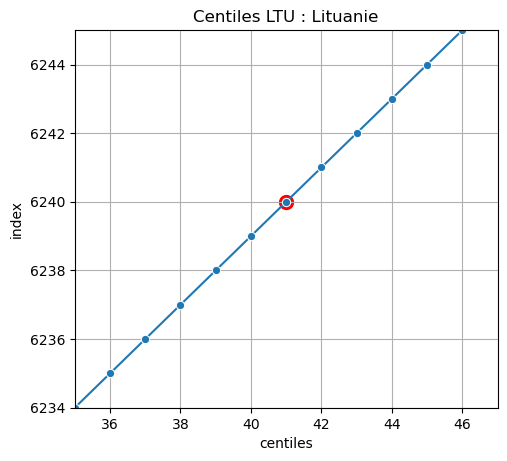

In [25]:
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.subplot(1, 2, 1)
verif = df_rech_quantile_quar[df_rech_quantile_quar['Country_Code']=="LTU"]
sns.lineplot(data=verif, x='quantile', y=verif.index,marker="o")
plt.axis([35, 47, 6234, 6245])
plt.grid()
plt.title("Centiles LTU : Lituanie")
plt.ylabel('index')
plt.xlabel('centiles')
plt.scatter(41,6240,marker="o",c='r',s=100)
# plt.savefig('OUTPUTS_FORMATION/P7_Lituanie_corrigée.jpg',dpi=300)
plt.show()
# verif[39:42]

# Mission 2

In [26]:
# on stocke la table finale pour les besoins d'affichage à venir
table_1 = df_rech_quantile_quar.copy()
table_2 = df_rech_quantile_quar.copy()
table_3 = df_rech_quantile_quar.copy()

In [27]:
# on regroupe par gdpppp et population en vue de la classification multi-paramètres à venir
table_1.set_index('TableName',inplace=True)
table_1 = table_1.groupby(['TableName']).agg({'gdpppp':np.sum, 'population':np.mean}) 

In [28]:
# on calcule la moyenne de l'indice du GINI en vue de la classification multi-paramètres à venir
table_2.drop(columns=['year_survey', 'quantile', 'income','population','gdpppp','population_vs_Mde_in_%','index'], inplace=True)
table_2 = table_2.groupby(['TableName']).agg('mean').reset_index(drop=False)
# table_2.set_index('TableName')
# table_2['GINI_avg'] = table_2.mean(numeric_only=True, axis=1)
# table_2 = table_2[['TableName','GINI_avg']]

In [29]:
table_2.set_index('TableName').head(2)

1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  ...  \
TableName                                                              ...   
Albania     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
Argentina   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

           2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  
TableName                                                              
Albania     NaN  29.0   NaN  34.6  32.9  33.7  33.2   NaN   NaN   NaN  
Argentina  42.6  41.3  40.9  41.6   NaN  42.0  41.1  41.3  42.9   NaN  

[2 rows x 61 columns]

In [30]:
table_2['GINI_avg'] = table_2.mean(numeric_only=True, axis=1)

In [31]:
table_2 = table_2[['TableName','GINI_avg']]

In [32]:
table_dendro = pd.merge(table_1,table_2, how="left", on="TableName")
table_dendro.head(2)

TableName     gdpppp  population   GINI_avg
0    Albania   729700.0   3002678.0  31.411111
1  Argentina  1322000.0  40080160.0  45.922581

In [33]:
# table_dendro.to_csv("OUTPUTS_FORMATION/P7_table_dendrogramme.csv", index = False)

In [34]:
# Affectation Indice GINI manquant moyen
table_dendro.loc[table_dendro['TableName'] == "Taiwan SAR China", 'GINI_avg'] = 33.8 #https://www.statista.com/statistics/922574/taiwan-gini-index/
table_dendro.loc[table_dendro['TableName'] == "Cambodia",         'GINI_avg'] = 34.6 
# nom des pays en index
table_dendro.set_index('TableName').head(2)

gdpppp  population   GINI_avg
TableName                                  
Albania     729700.0   3002678.0  31.411111
Argentina  1322000.0  40080160.0  45.922581

## Classification CAH (dendrogramme)

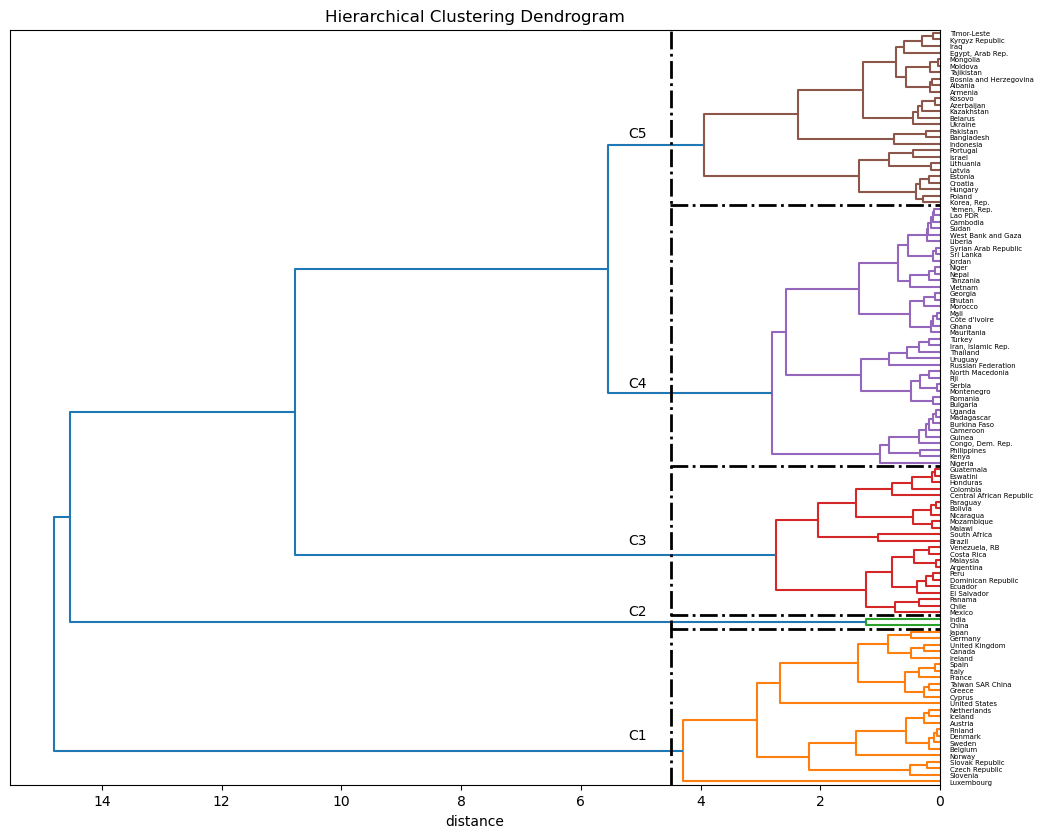

In [35]:
# préparation des données pour le clustering
table_vf = table_dendro[['gdpppp','population','GINI_avg']]
# table_vf.set_index('TableName')

X     = table_vf.values
# names = list(table_vf.index)
names = list(table_dendro['TableName'])

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)     #Compute the mean and std to be used for later scaling
# std_scale = preprocessing.RobustScaler().fit(X)         #Removes the median and scales the data according to the quantile range
X_scaled  = std_scale.transform(X)                      #Perform standardization by centering and scaling

# Clustering hiérarchique
Z = linkage(X_scaled, method='ward', metric='euclidean', optimal_ordering=False)

# Affichage du dendrogramme
plot_dendrogram(Z, names)
plt.axvline(x=4.5   ,color='k',ls='-.',lw=2)                        
plt.axhline(y=240  ,color='k',ls='-.',lw=2,xmin=0.71, xmax=1)   
plt.axhline(y=260  ,color='k',ls='-.',lw=2,xmin=0.71, xmax=1)   
plt.axhline(y=490  ,color='k',ls='-.',lw=2,xmin=0.71, xmax=1)   
plt.axhline(y=890  ,color='k',ls='-.',lw=2,xmin=0.71, xmax=1) 
plt.annotate('C1', xy=(2, 1), xytext=(5.2, 70))
plt.annotate('C2', xy=(2, 1), xytext=(5.2, 260))
plt.annotate('C3', xy=(2, 1), xytext=(5.2, 370))
plt.annotate('C4', xy=(2, 1), xytext=(5.2, 610))
plt.annotate('C5', xy=(2, 1), xytext=(5.2, 995))
plt.savefig('OUTPUTS_FORMATION/P7_dendrogram.jpg',dpi=300)
plt.show()

In [36]:
# Coupage du dendrogramme en n clusters
n_cluster = 5
clusters = fcluster(Z, n_cluster, criterion='maxclust')

# Comparaison des clusters trouvés avec les classification des pays
gpe_clust = pd.DataFrame({ "cluster": clusters, "nb_pays": names})
gpe_clust.pivot_table(columns="cluster", aggfunc=len, fill_value=0) 

cluster   1  2   3   4   5
nb_pays  24  2  23  40  27

In [37]:
table_vf.insert(1, "Cluster", clusters, allow_duplicates=False)
# table_vf.to_csv("OUTPUTS_FORMATION/P7_List_per_clusters.csv", index = True)

## Visualisation MAP

In [38]:
Pays = table_vf[['Cluster']]

my_colors = ['orange','green','red','violet','brown','brown']

data = [dict(type='choropleth',
             locations    = table_dendro['TableName'],#table_vf.index,
             text         = table_dendro['TableName'],#table_vf.index,
             locationmode = 'country names', #'ISO-3', 'USA-states', 'country names', 'geojson-id'
             z            = Pays['Cluster'],
             colorbar     = {'title':'Cluster Group'},
             marker_line_color='black',
             marker_line_width=0.5,
             colorscale = my_colors,
             zmin=1,
             zmax=6,
             showscale=True
            )
       ]

layout = dict(title='Grouping of Countries based on Clustering',
              geo=dict(
                          {'scope':'world'},
                          showframe = True, 
                          projection = {'type':'equirectangular'},
                          showcountries = True,
                      )
             )
map3 = dict(data=data, layout=layout)
iplot(map3)

In [39]:
table_moy_var = table_vf.groupby(['Cluster']).agg({
                                                    'gdpppp':np.mean,
                                                    'population':np.mean,
                                                    'GINI_avg':np.mean,
                                                  }).round(2)
#------------------------------------------------------------------------------------------------------------------------------
# table_moy_var.to_csv("OUTPUTS_FORMATION/P7_Mean_Var_per_Cluster.csv",index=True)
table_moy_var.head()

gdpppp    population  GINI_avg
Cluster                                    
1        3428095.83  3.727029e+07     30.72
2         425400.00  1.264602e+09     36.68
3         736720.87  2.877335e+07     51.34
4         454223.00  3.069489e+07     39.26
5         968722.59  3.354504e+07     31.95

## Visualisation RADAR

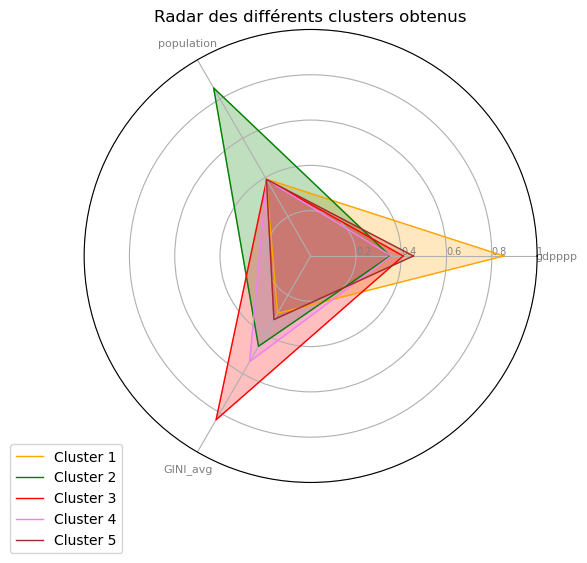

In [40]:
# Choix du set data (à partir de la table des valeurs moyennées par Cluster): 
df_radar = table_moy_var.copy()
df_radar = df_radar.reset_index()
df_radar_VAR = df_radar[[
                        'gdpppp',
                        'population',
                        'GINI_avg',
                        ]]
df_radar_CLUST = df_radar[['Cluster']]

# normalization : (df-df.mean())/df.std()
df_radar_norm_mean = (df_radar_VAR-df_radar_VAR.mean())/df_radar_VAR.std()
df_radar_norm_mean.insert(0, "Cluster", df_radar_CLUST, allow_duplicates=False)
# normalization : (df-df.min())/(df.max()-df.min())
df_radar_norm_minmax =(df_radar_VAR-df_radar_VAR.min())/(df_radar_VAR.max()-df_radar_VAR.min())
df_radar_norm_minmax.insert(0, "Cluster", df_radar_CLUST, allow_duplicates=False)
# normalization : 1/(1+exp(-(x-mean)/std))
df_radar_norm_softmax = 1/(1+np.exp(-(df_radar_VAR-df_radar_VAR.mean())/df_radar_VAR.std()))
df_radar_norm_softmax.insert(0, "Cluster", df_radar_CLUST, allow_duplicates=False)

# Nb de variable
df = df_radar_norm_softmax.copy()
categories=list(df)[1:]
N = len(categories)
 
# On crée les angles entre les diff variables?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})

# Initialisation du radar
ax = plt.subplot(111, polar=True)
 
# 1 axe par var + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2,0.4,0.6,0.8,1], ['0.2','0.4','0.6','0.8','1'], color="grey", size=7)
plt.ylim(0,1)
plt.title('Radar des différents clusters obtenus')
                                         
# Refined
alpha = 0.25
values=df.loc[0].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 1",color='orange')
ax.fill(angles, values, 'b', alpha=alpha,color='orange')
 
values=df.loc[1].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 2",color='green')
ax.fill(angles, values, 'r', alpha=alpha,color='green')

values=df.loc[2].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 3",color='red')
ax.fill(angles, values, 'b', alpha=alpha,color='red')
 
values=df.loc[3].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 4",color='violet')
ax.fill(angles, values, 'r', alpha=alpha,color='violet')

values=df.loc[4].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 5",color='brown')
ax.fill(angles, values, 'b', alpha=alpha,color='brown')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.savefig('OUTPUTS_FORMATION/P7_radar.jpg',dpi=300)
plt.show()

In [41]:
# on choisit 5 pays à l'aide des résultats de la classification
df_pays_choisis = df_rech_quantile_quar.query('Country_Code == ["BRA","FRA","CHN","CIV","UKR"]', inplace=False) 

## Distributions de revenus

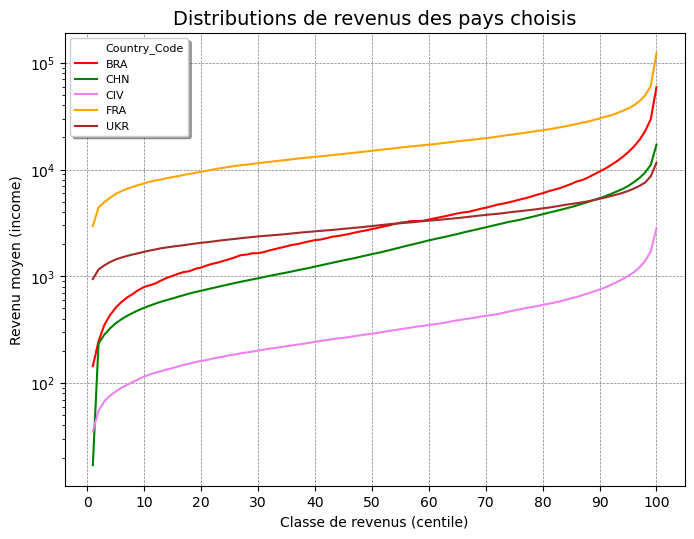

In [42]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})
colors    = {"BRA":'red',"FRA":'orange',"CHN":'green',"CIV":'violet',"UKR":'brown'} 
# colors    = {"ZAF":'red',"SVN":'orange',"CHN":'green',"CIV":'violet',"UKR":'brown'} 
sns.lineplot(data=df_pays_choisis, x="quantile", y="income", hue="Country_Code", palette = colors)
plt.yscale('log')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(0,101,10))
plt.legend(shadow=True, loc='upper left',fontsize=8)
plt.title('Distributions de revenus des pays choisis',fontsize=14)
plt.xlabel('Classe de revenus (centile)',fontsize=10)
plt.ylabel('Revenu moyen (income)',fontsize=10)
plt.savefig('OUTPUTS_FORMATION/P7_qlq_Distri_Rev.jpg',dpi=300)
plt.show()

## Courbes de Lorenz

In [43]:
# Création array d'étude
arr = np.array(df_pays_choisis['income'])

In [44]:
def gini(arr):
    count = arr.size
    coefficient = 2 / count
    indexes = np.arange(1, count + 1)
    weighted_sum = (indexes * arr).sum()
    total = arr.sum()
    constant = (count + 1) / count
    return coefficient * weighted_sum / total - constant

def lorenz(arr):
    scaled_prefix_sum = arr.cumsum() / arr.sum() # ratio sum/total_sum
    return np.insert(scaled_prefix_sum, 0, 0)    # ajout valeur 0 pour borner le tracé
lorenz_curve = lorenz(arr)

['BRA', 'CHN', 'CIV', 'FRA', 'UKR']


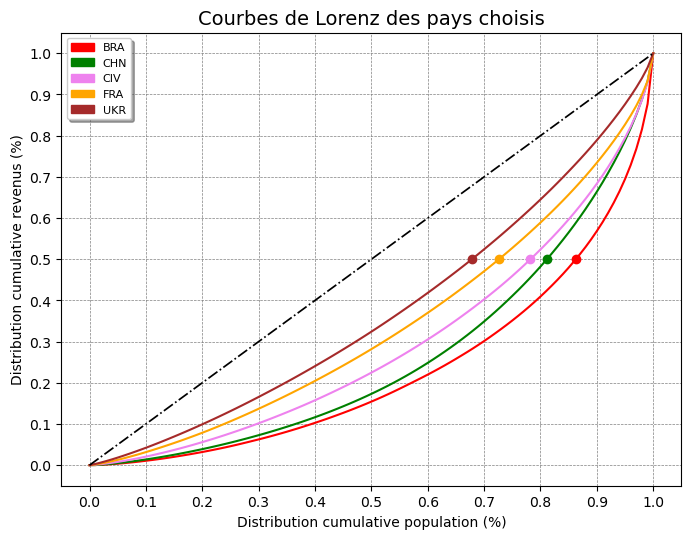

In [45]:
country_labels = list(df_pays_choisis['Country_Code'].unique())
print(country_labels)
lorenz_curve1 = lorenz(arr[:100])                                                  
lorenz_curve2 = lorenz(arr[100:200])                                               
lorenz_curve3 = lorenz(arr[200:300])                                               
lorenz_curve4 = lorenz(arr[300:400])                                              
lorenz_curve5 = lorenz(arr[400:500])                                               
# lorenz_curve6 = lorenz(arr[500:600])                                               
x_values = np.linspace(0.0, 1.0, lorenz_curve1.size)
# x_values_99 = np.linspace(0.0, 1.0, lorenz_curve5.size)
colors    = {"BRA":'red',"FRA":'orange',"CHN":'green',"CIV":'violet',"UKR":'brown'} 
# colors    = {"ZAF":'red',"SVN":'orange',"CHN":'green',"CIV":'violet',"UKR":'brown'} 
plt.plot(x_values, lorenz_curve1, color='red'   )
plt.plot(x_values, lorenz_curve2, color='green' )
plt.plot(x_values, lorenz_curve3, color='violet')
plt.plot(x_values, lorenz_curve4, color='orange')
plt.plot(x_values, lorenz_curve5, color='brown' )
# plt.plot(x_values, lorenz_curve6, color='brown')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.plot([0,1], [0,1], color='black', ls='-.', lw=1.25)
plt.xlabel('Distribution cumulative population (%)',fontsize=10)
plt.ylabel('Distribution cumulative revenus (%)',fontsize=10)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
my_colors = {
            country_labels[0]:'red',country_labels[1]:'green',                    
                country_labels[2]:'violet',country_labels[3]:'orange',                 
                    country_labels[4]:'brown'           
            }          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
plt.legend(handles, lab_col, ncol=1, shadow=True, loc='upper left',fontsize=8)
plt.title('Courbes de Lorenz des pays choisis',fontsize=14)

# on va interpoler par itération sur la courbe de Lorenz pour récupération du y pr x = 50% (i.e "populations égalitaires")
# on positionne le point de partage
plt.plot(0.863,np.interp(0.863,np.linspace(0.0, 1.0, lorenz_curve1.size),lorenz_curve1),color='red'   ,marker = 'o')
plt.plot(0.811,np.interp(0.811,np.linspace(0.0, 1.0, lorenz_curve2.size),lorenz_curve2),color='green' ,marker = 'o')
plt.plot(0.782,np.interp(0.782,np.linspace(0.0, 1.0, lorenz_curve3.size),lorenz_curve3),color='violet',marker = 'o')
plt.plot(0.726,np.interp(0.726,np.linspace(0.0, 1.0, lorenz_curve4.size),lorenz_curve4),color='orange',marker = 'o')
plt.plot(0.678,np.interp(0.678,np.linspace(0.0, 1.0, lorenz_curve5.size),lorenz_curve5),color='brown' ,marker = 'o')
# plt.plot(0.785,np.interp(0.785,np.linspace(0.0, 1.0, lorenz_curve6.size),lorenz_curve6),color='brown',marker = 'o')

plt.savefig('OUTPUTS_FORMATION/P7_qlq_Lorenz.jpg',dpi=300)
plt.show()

## Evolutions de l'indice de GINI

In [46]:
df_pays_choisis_boxplot = df_pays_choisis.copy()
# on écarte les colonnes inutiles
df_pays_choisis.drop(columns=['year_survey', 'quantile', 'income', 'gdpppp', 'Region',
                       'IncomeGroup', 'TableName','population', 'population_vs_Mde_in_%'], inplace=True)
df_pays_choisis = df_pays_choisis.groupby(['Country_Code']).agg('mean').reset_index(drop=False)#({'income':np.mean})

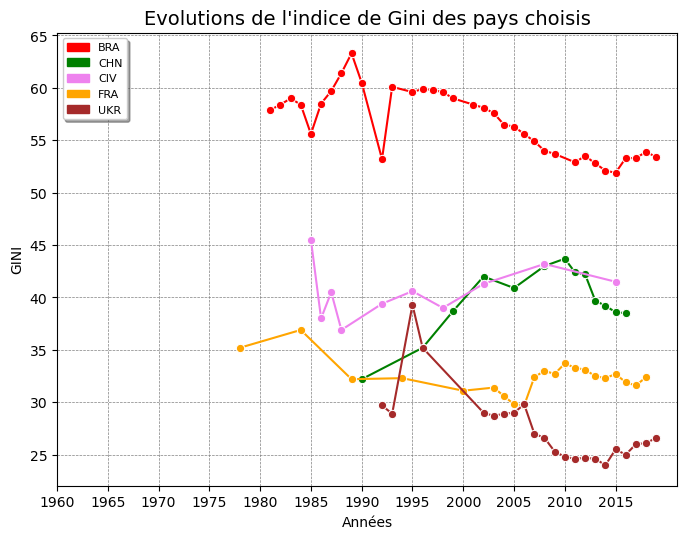

In [47]:
# transposition du dataframe
df_pays_choisis_T = df_pays_choisis.T
# replace header with 1st row data
df_pays_choisis_T.columns = df_pays_choisis_T.iloc[0]
df_pays_choisis_T = df_pays_choisis_T[1:]
df_pays_choisis_T = df_pays_choisis_T.reset_index()
# conversion numérique des données
df_pays_choisis_T = df_pays_choisis_T.apply(pd.to_numeric, errors='coerce')
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})
sns.lineplot(data=df_pays_choisis_T, x='index',y=df_pays_choisis_T.columns.values.tolist()[1],color='red'   ,marker = 'o')
sns.lineplot(data=df_pays_choisis_T, x='index',y=df_pays_choisis_T.columns.values.tolist()[2],color='green' ,marker = 'o')
sns.lineplot(data=df_pays_choisis_T, x='index',y=df_pays_choisis_T.columns.values.tolist()[3],color='violet',marker = 'o')
sns.lineplot(data=df_pays_choisis_T, x='index',y=df_pays_choisis_T.columns.values.tolist()[4],color='orange',marker = 'o')
sns.lineplot(data=df_pays_choisis_T, x='index',y=df_pays_choisis_T.columns.values.tolist()[5],color='brown' ,marker = 'o')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(int(df_pays_choisis_T['index'].min()),int(df_pays_choisis_T['index'].max()),5))
my_colors = {
            country_labels[0]:'red',country_labels[1]:'green',                    
                country_labels[2]:'violet',country_labels[3]:'orange',                 
                    country_labels[4]:'brown'           
            } 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]   
plt.legend(handles, lab_col, ncol=1, shadow=True, loc='upper left',fontsize=8)
plt.title("Evolutions de l'indice de Gini des pays choisis",fontsize=14)
plt.xlabel('Années',fontsize=10)
plt.ylabel('GINI',fontsize=10)
plt.savefig('OUTPUTS_FORMATION/P7_qlq_indices_GINI.jpg',dpi=300)
plt.show()

## Classification par GINI

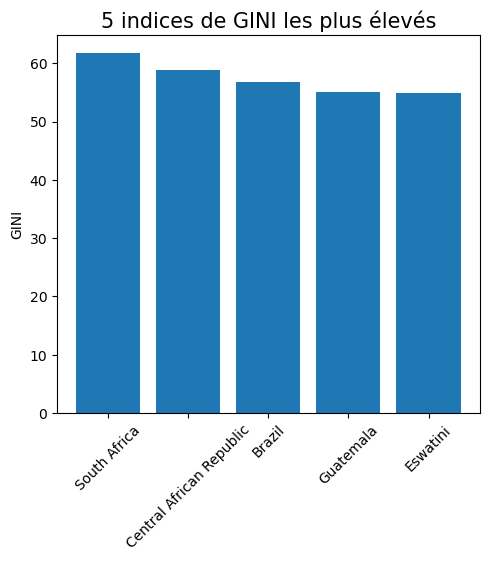

In [48]:
GINI_max = table_2.nlargest(5,'GINI_avg').round(1).sort_values('GINI_avg',ascending=0)
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.subplot(1, 2, 1)
plt.bar(GINI_max['TableName'],GINI_max['GINI_avg'])
plt.title('5 indices de GINI les plus élevés',fontsize=15)
plt.xticks(rotation = 45)
plt.ylabel("GINI",fontsize=10)
plt.savefig('OUTPUTS_FORMATION/P7_5_GINI_max.jpg',dpi=300, bbox_inches='tight')
plt.show()

BRICS group (topo)

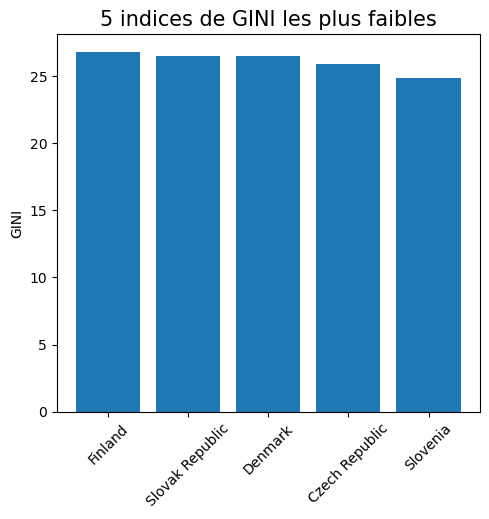

In [49]:
GINI_min = table_2.nsmallest(5,'GINI_avg').round(1).sort_values('GINI_avg',ascending=0)
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.subplot(1, 2, 1)
plt.bar(GINI_min['TableName'],GINI_min['GINI_avg'])
plt.title('5 indices de GINI les plus faibles',fontsize=15)
plt.xticks(rotation = 45)
plt.ylabel("GINI",fontsize=10)
plt.savefig('OUTPUTS_FORMATION/P7_5_GINI_min.jpg',dpi=300, bbox_inches='tight')
plt.show()

Position of France : 36ème


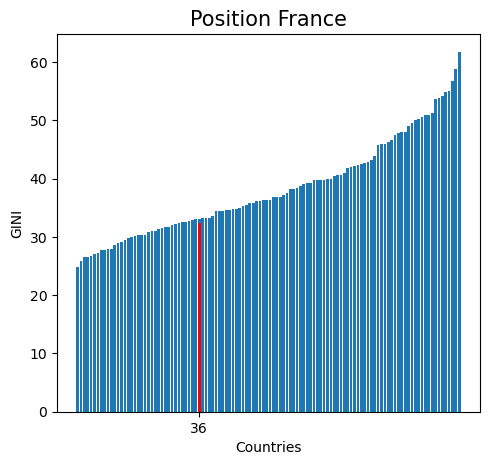

TableName  GINI_avg
36    France      32.4

In [50]:
# Rang de la France
indice_FRA = table_2.index[table_2['TableName']=='France'].tolist()[0]
print('\x1b[6;31;40m' + 'Position of France : '+str(indice_FRA)+'ème'+'\x1b[0m')
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.subplot(1, 2, 1)
plt.bar(table_2['TableName'],table_2['GINI_avg'].sort_values())
plt.title('Position France',fontsize=15)
plt.xlabel('Countries',fontsize=10)
plt.xticks([indice_FRA], [indice_FRA])
plt.ylabel("GINI",fontsize=10)
FRA = table_2[table_2['TableName']=='France']
plt.bar(FRA['TableName'],FRA['GINI_avg'],color='r')
plt.savefig('OUTPUTS_FORMATION/P7_Pos_France.jpg',dpi=300)
plt.show()
table_2[table_2['TableName']=='France'].round(1)

# Mission 3

## Prise en main code génération [c_parent]

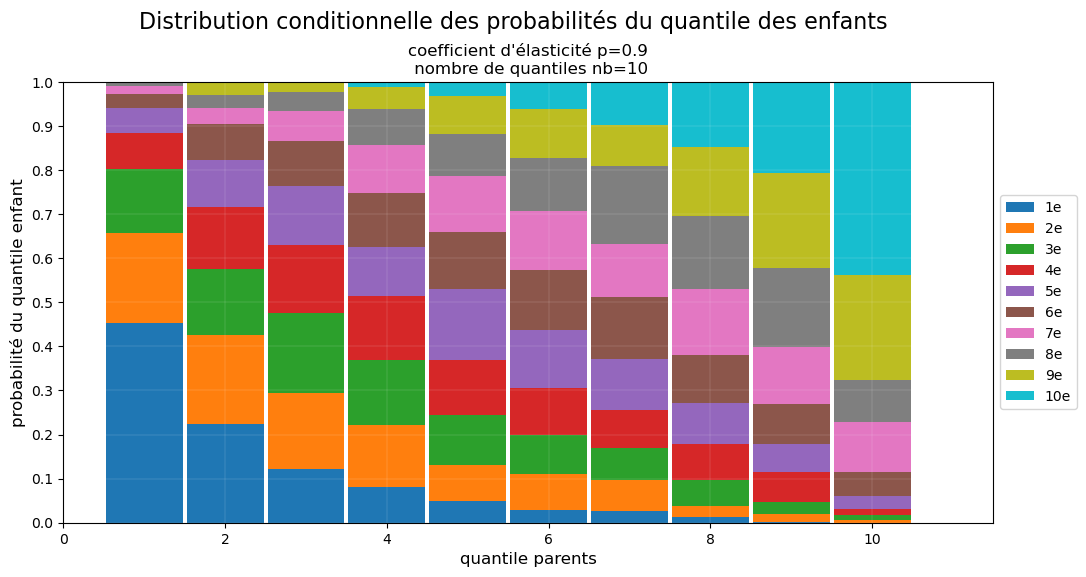


P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.094


In [51]:
import scipy.stats as st
from collections import Counter

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)


def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])


def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample


def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    if total == 0 :
        return [0] * nb_quantiles
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   


def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 


def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure(figsize=(12,6))
    cumul = np.array([0] * nb_quantiles)
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)
    plt.axis([0.5, nb_quantiles*1.15 ,0.1,1])
    
    plt.suptitle("Distribution conditionnelle des probabilités du quantile des enfants", fontsize=16)
    plt.title("coefficient d'élasticité p=" + str(p) + "\n nombre de quantiles nb=" + str(nb_quantiles), fontsize=12)
    plt.subplots_adjust(top=.86)
#     plt.legend(shadow=False, loc='best',fontsize=10) 
    plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlabel("quantile parents", fontsize=12)
    plt.ylabel("probabilité du quantile enfant", fontsize=12)
    plt.xticks(range(0,int(nb_quantiles*1.1),2))
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) 
    plt.grid(color="w",lw=0.1)
    plt.show()

    
def proba_cond(c_i_parent, c_i_child, mat):
#     return mat[c_i_child, c_i_parent]
    return mat[c_i_child-1, c_i_parent-1]



pj           = 0.9                  # coefficient d'élasticité du pays j
nb_quantiles = 10                   # nombre de quantiles (nombre de classes de revenu)
n            = 500*nb_quantiles     # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample             = compute_quantiles(y_child, y_parents, nb_quantiles)
cd                 = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles)
# print(cd)d

c_i_child  = 5
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

In [52]:
# on ajoute à sample les col [coef elasticité] et [proba]
for j, row in sample.iterrows():
    sample.loc[j,'coef_elasticite'] = pj
    sample.loc[j,'proba_cond']      = proba_cond(sample.iloc[j,sample.columns.get_loc('c_i_parent')], sample.iloc[j,sample.columns.get_loc('c_i_child')], cd)
sample
# sample.to_csv("OUTPUTS_FORMATION/P7_sample.csv", index = False)

y_child  y_parents  c_i_child  c_i_parent  coef_elasticite  proba_cond
0     0.965108   0.816490          5           5              0.9       0.160
1     0.288832   0.348414          2           2              0.9       0.202
2     0.879097   0.576950          5           3              0.9       0.134
3     1.134719   1.500709          6           7              0.9       0.140
4     0.056045   0.118760          1           1              0.9       0.454
...        ...        ...        ...         ...              ...         ...
4995  0.392902   1.377212          3           7              0.9       0.074
4996  1.173752   1.072381          6           6              0.9       0.138
4997  0.301483   1.387675          2           7              0.9       0.070
4998  9.214088   1.077692         10           6              0.9       0.062
4999  0.526570   1.171183          4           6              0.9       0.106

[5000 rows x 6 columns]

## Téléchargement des données WID

In [53]:
url_elast = 'INPUTS_FORMATION/P7_IGE_income_coef_elasticite.csv'
coef_elast = pd.read_csv(url_elast, sep=',')

url_elast_region = 'INPUTS_FORMATION/P7_IGE_income_coef_elasticite_region.csv'
coef_elast_region = pd.read_csv(url_elast_region, sep=',')

In [54]:
# cleaning : drop useless columns & rows
coef_elast=coef_elast[['countryname', 'iso3', 'region', 'incgroup4','year', 'parent', 'child','obs','IGEincome']]
coef_elast.drop(coef_elast.loc[(coef_elast['child']=='daughter')].index, inplace=True) 
coef_elast.drop(coef_elast.loc[(coef_elast['child']=='son')].index, inplace=True) 
coef_elast.drop(coef_elast.loc[(coef_elast['parent']=='dad')].index, inplace=True) 
coef_elast.drop(coef_elast.loc[(coef_elast['parent']=='max')].index, inplace=True) 
coef_elast.drop(coef_elast.loc[(coef_elast['parent']=='mom')].index, inplace=True) 
coef_elast.head()

countryname iso3                 region            incgroup4  year parent  \
0   Afghanistan  AFG             South Asia           Low income  1980    avg   
12       Angola  AGO     Sub-Saharan Africa  Upper middle income  1980    avg   
24      Albania  ALB  Europe & Central Asia  Upper middle income  1940    avg   
36      Albania  ALB  Europe & Central Asia  Upper middle income  1950    avg   
48      Albania  ALB  Europe & Central Asia  Upper middle income  1960    avg   

   child     obs  IGEincome  
0    all  3956.0        NaN  
12   all   459.0        NaN  
24   all   210.0        NaN  
36   all   397.0        NaN  
48   all   513.0        NaN

In [55]:
# grouper par pays (suppression des lignes/années)
coef_elast = coef_elast.groupby(['countryname','iso3','region']).agg({'IGEincome':np.mean}).reset_index(drop=False)
coef_elast.head()

countryname iso3                 region  IGEincome
0  Afghanistan  AFG             South Asia        NaN
1      Albania  ALB  Europe & Central Asia   0.815874
2       Angola  AGO     Sub-Saharan Africa        NaN
3      Armenia  ARM  Europe & Central Asia        NaN
4    Australia  AUS            High income   0.275000

<AxesSubplot:>

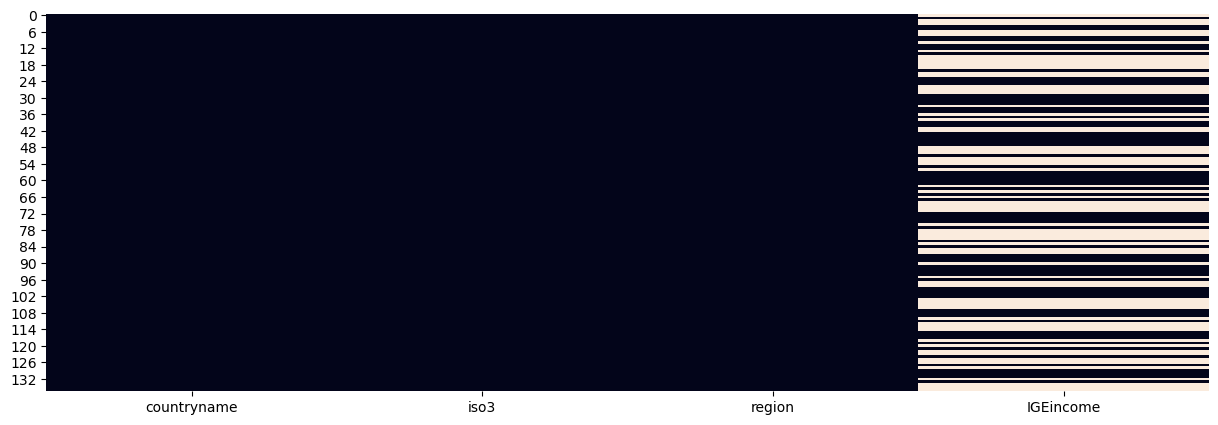

In [56]:
# Etat des lieux sur les données manquantes
plt.figure(figsize=(15,5))
sns.heatmap(coef_elast.isna(), cbar=False)

In [57]:
print(coef_elast['region'].unique())
coef_elast_region

['South Asia' 'Europe & Central Asia' 'Sub-Saharan Africa' 'High income'
 'Latin America & Caribbean' 'East Asia & Pacific'
 'Middle East & North Africa']


region         Base case    \
0  Nordic European countries and Canada              0.20   
1    Europe (except nordic  countries)               0.40   
2                 Australia/New Zealand/USA          0.40   
3                 Asia                               0.50   
4                 Latin America/Africa               0.66   

   Optimistic (high mobility)    Pessimistic (low mobility)  
0                          0.15                         0.3  
1                          0.30                         0.5  
2                          0.30                         0.5  
3                          0.40                         0.6  
4                          0.50                         0.9

## Combinaison IGEincome + IGE_région

In [58]:
# création scolonne contenant les IGEIncome_corrigés
# list_pays_high_income = tuple(H_incom['iso3'].unique())
n = len(coef_elast)
for i in range(n):
    val_prod = coef_elast.iloc[i,coef_elast.columns.get_loc('iso3')]
    val_IGE  = coef_elast.iloc[i,coef_elast.columns.get_loc('IGEincome')]
    if (val_prod in (coef_elast[coef_elast['region']   == "High income"]['iso3'].unique())):
        coef_elast.loc[i,'IGEincome_corrige'] = 0.40 
    elif (val_prod in (coef_elast[coef_elast['region'] == "South Asia"]['iso3'].unique())):
        coef_elast.loc[i,'IGEincome_corrige'] = 0.50 
    elif (val_prod in (coef_elast[coef_elast['region'] == "Sub-Saharan Africa"]['iso3'].unique())):
        coef_elast.loc[i,'IGEincome_corrige'] = 0.66 
    elif (val_prod in (coef_elast[coef_elast['region'] == "Europe & Central Asia"]['iso3'].unique())):
        coef_elast.loc[i,'IGEincome_corrige'] = 0.40 
    elif (val_prod in (coef_elast[coef_elast['region'] == "Latin America & Caribbean"]['iso3'].unique())):
        coef_elast.loc[i,'IGEincome_corrige'] = 0.66 
    elif (val_prod in (coef_elast[coef_elast['region'] == "East Asia & Pacific"]['iso3'].unique())):
        coef_elast.loc[i,'IGEincome_corrige'] = 0.50 
    elif (val_prod in (coef_elast[coef_elast['region'] == "Middle East & North Africa"]['iso3'].unique())):
        coef_elast.loc[i,'IGEincome_corrige'] = 0.66
    else :
        coef_elast.loc[i,'IGEincome_corrige'] = 'toto'
coef_elast.head()

countryname iso3                 region  IGEincome  IGEincome_corrige
0  Afghanistan  AFG             South Asia        NaN               0.50
1      Albania  ALB  Europe & Central Asia   0.815874               0.40
2       Angola  AGO     Sub-Saharan Africa        NaN               0.66
3      Armenia  ARM  Europe & Central Asia        NaN               0.40
4    Australia  AUS            High income   0.275000               0.40

In [59]:
# Correction des IGEincome manquants avec les IGEincome nouvellement créés
n = len(coef_elast)
for i in range(n):
    coef_elast['IGEincome'] = np.where(coef_elast['IGEincome'].isna(),coef_elast['IGEincome_corrige'],coef_elast['IGEincome'])
coef_elast.head()

countryname iso3                 region  IGEincome  IGEincome_corrige
0  Afghanistan  AFG             South Asia   0.500000               0.50
1      Albania  ALB  Europe & Central Asia   0.815874               0.40
2       Angola  AGO     Sub-Saharan Africa   0.660000               0.66
3      Armenia  ARM  Europe & Central Asia   0.400000               0.40
4    Australia  AUS            High income   0.275000               0.40

In [60]:
# Suppression colonne IGEincome_corrige
coef_elast.drop(columns=['IGEincome_corrige'], inplace=True)
coef_elast.rename(columns={'iso3':'Country_Code'}, inplace=True)
coef_elast.head()

countryname Country_Code                 region  IGEincome
0  Afghanistan          AFG             South Asia   0.500000
1      Albania          ALB  Europe & Central Asia   0.815874
2       Angola          AGO     Sub-Saharan Africa   0.660000
3      Armenia          ARM  Europe & Central Asia   0.400000
4    Australia          AUS            High income   0.275000

<AxesSubplot:>

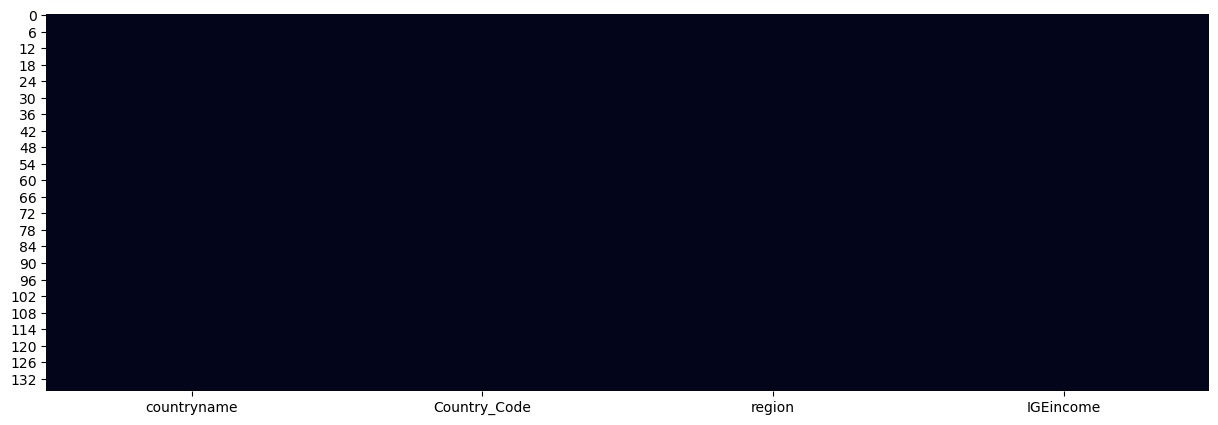

In [61]:
# Etat des lieux sur les données manquantes
plt.figure(figsize=(15,5))
sns.heatmap(coef_elast.isna(), cbar=False)

## Récupération du GINI_moyen par pays

In [62]:
table_3.drop(columns=['year_survey', 'quantile', 'income','population','gdpppp','population_vs_Mde_in_%','index'], inplace=True)
# on recalcule la moyenne de l'indice du GINI (comme pour mission 2)
table_3 = table_3.groupby(['Country_Code']).agg('mean').reset_index(drop=False)

In [63]:
table_3.set_index('Country_Code').head(2)

1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  ...  \
Country_Code                                                              ...   
ALB            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
ARG            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

              2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  
Country_Code                                                              
ALB            NaN  29.0   NaN  34.6  32.9  33.7  33.2   NaN   NaN   NaN  
ARG           42.6  41.3  40.9  41.6   NaN  42.0  41.1  41.3  42.9   NaN  

[2 rows x 61 columns]

In [64]:
table_3['GINI_avg'] = table_3.mean(numeric_only=True, axis=1)

In [65]:
table_3 = table_3[['Country_Code','GINI_avg']]
table_3.head(2)

Country_Code   GINI_avg
0          ALB  31.411111
1          ARG  45.922581

## Reprise du df et jointure GINI moyen

In [66]:
# jointure df principal + GINI_avg
df_rech_quantile_quar = pd.merge(df_rech_quantile_quar, table_3, how="left", on="Country_Code")

# suppression des colonnes inutiles
df_rech_quantile_quar=df_rech_quantile_quar[['Country_Code', 'TableName', 'quantile', 'income', 
                                                 'gdpppp','population', 'GINI_avg']]
df_rech_quantile_quar.head()

Country_Code TableName  quantile  income  gdpppp  population   GINI_avg
0          ALB   Albania         1   729.0  7297.0   3002678.0  31.411111
1          ALB   Albania         2   917.0  7297.0   3002678.0  31.411111
2          ALB   Albania         3  1011.0  7297.0   3002678.0  31.411111
3          ALB   Albania         4  1087.0  7297.0   3002678.0  31.411111
4          ALB   Albania         5  1133.0  7297.0   3002678.0  31.411111

In [67]:
# on stocke la table
df_rech_quantile_fiv = df_rech_quantile_quar.copy()

## Jointure coef d'élasticité

In [68]:
# jointure df principal + IGEincome
df_rech_quantile_fiv = pd.merge(df_rech_quantile_fiv, coef_elast, how="left", on="Country_Code")

<AxesSubplot:>

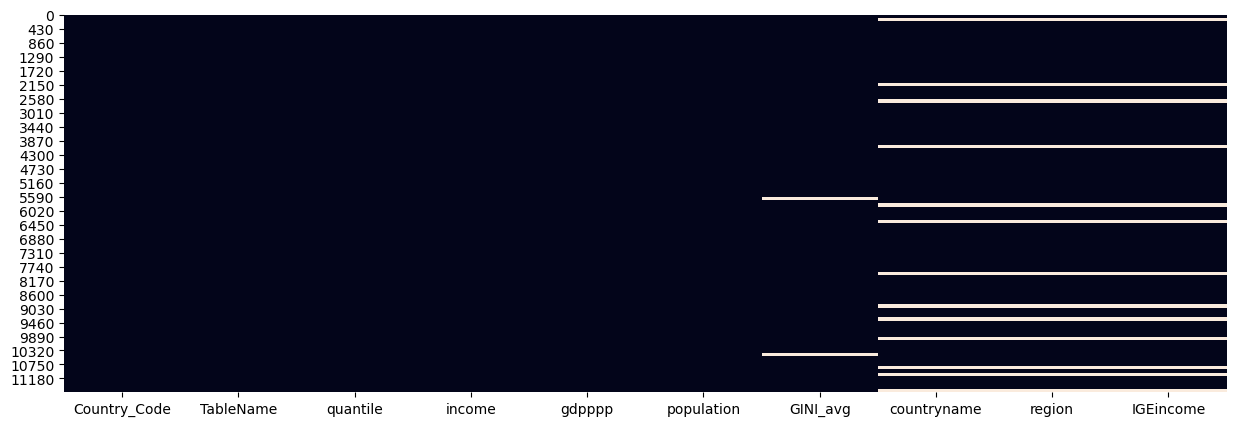

In [69]:
# Etat des lieux sur les données manquantes
plt.figure(figsize=(15,5))
sns.heatmap(df_rech_quantile_fiv.isna(), cbar=False)

In [70]:
# affectation GINI_avg manquants TWN et CBD (comme pour mission 2) 
df_rech_quantile_fiv.loc[df_rech_quantile_fiv['TableName'] == "Taiwan SAR China", 'GINI_avg'] = 33.8 #https://www.statista.com/statistics/922574/taiwan-gini-index/
df_rech_quantile_fiv.loc[df_rech_quantile_fiv['TableName'] == "Cambodia",         'GINI_avg'] = 34.6 

<AxesSubplot:>

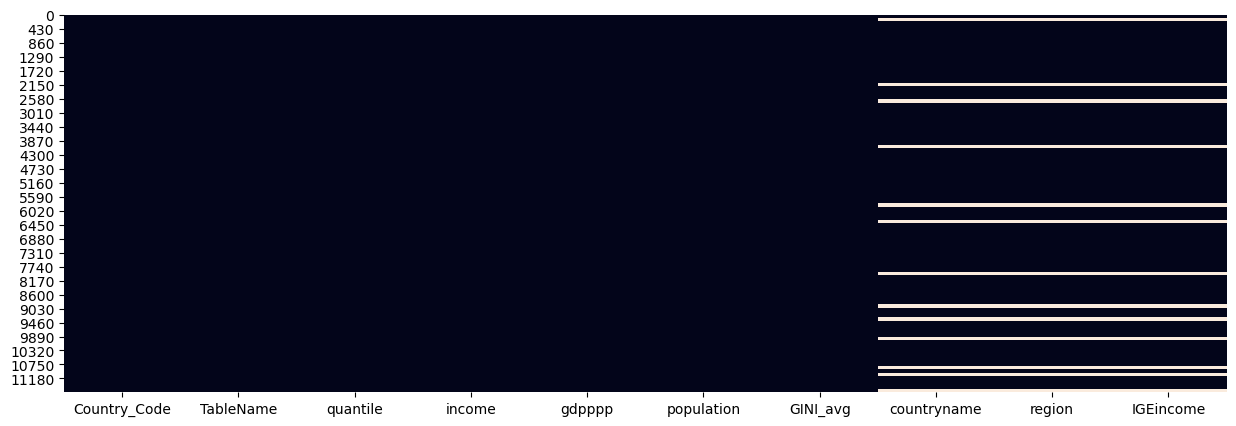

In [71]:
# Etat des lieux sur les données manquantes
plt.figure(figsize=(15,5))
sns.heatmap(df_rech_quantile_fiv.isna(), cbar=False)
# df_rech_quantile_fiv.to_csv("OUTPUTS_FORMATION/P7_df_rech_quantile_fiv_init.csv", index = False)

## Affectation IGEincome (selon règle région)

In [72]:
# liste pays sans infos + IGEincome
df_rech_quantile_fiv[df_rech_quantile_fiv['IGEincome'].isna()]['Country_Code'].unique()

array(['ARG', 'CRI', 'DOM', 'HND', 'XKX', 'LUX', 'NIC', 'PRY', 'SLV',
       'SYR', 'URY', 'VEN', 'COD'], dtype=object)

In [73]:
# création manuelle dictionnaire pour affectation coefs manquants
dict_pays = {"ARG":0.66,"COD":0.66,"CRI":0.66,"DOM":0.66,"HND":0.66,"LUX":0.40,"NIC":0.66,
                 "PRY":0.66,"SLV":0.66,"SYR":0.50,"URY":0.66,"VEN":0.66,"XKX":0.40}

n = len(df_rech_quantile_fiv)
for i in range(n):
    val_CCode  = df_rech_quantile_fiv.iloc[i,df_rech_quantile_fiv.columns.get_loc('Country_Code')]
    for cle, valeur in dict_pays.items():
        if (val_CCode == cle):
            df_rech_quantile_fiv.loc[i,'IGEincome'] = valeur

In [74]:
# suppression colonnes inutiles
df_rech_quantile_fiv.drop(columns=['countryname','region'], inplace=True)

<AxesSubplot:>

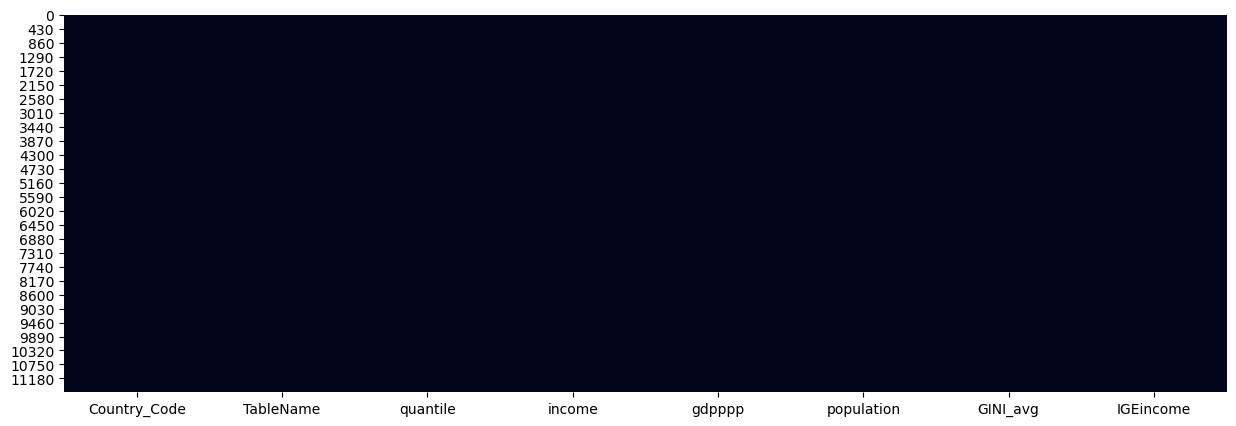

In [75]:
# Etat des lieux sur les données manquantes
plt.figure(figsize=(15,5))
sns.heatmap(df_rech_quantile_fiv.isna(), cbar=False)
# df_rech_quantile_fiv.to_csv("OUTPUTS_FORMATION/P7_df_rech_quantile_fiv_vf.csv", index = False)

## Clonage données (x500)

In [76]:
# on clone le df
df_WID_500 = pd.concat([df_rech_quantile_fiv]*500, ignore_index=True)
print(df_WID_500.shape)
df_WID_500.head()

(5800000, 8)


Country_Code TableName  quantile  income  gdpppp  population   GINI_avg  \
0          ALB   Albania         1   729.0  7297.0   3002678.0  31.411111   
1          ALB   Albania         2   917.0  7297.0   3002678.0  31.411111   
2          ALB   Albania         3  1011.0  7297.0   3002678.0  31.411111   
3          ALB   Albania         4  1087.0  7297.0   3002678.0  31.411111   
4          ALB   Albania         5  1133.0  7297.0   3002678.0  31.411111   

   IGEincome  
0   0.815874  
1   0.815874  
2   0.815874  
3   0.815874  
4   0.815874

In [77]:
# récupération des 116 coefficients des 116 pays
country_grpby = df_rech_quantile_fiv.groupby(['Country_Code']).agg({'IGEincome':'mean'})
country_grpby

IGEincome
Country_Code           
ALB            0.815874
ARG            0.660000
ARM            0.400000
AUT            0.245267
AZE            0.400000
...                 ...
VEN            0.660000
VNM            0.480000
XKX            0.400000
YEM            0.660000
ZAF            0.677000

[116 rows x 1 columns]

In [78]:
# création d'une liste des 116 coefficients
coeff = list(country_grpby['IGEincome'])
nb_quantiles = 100                  
n            = 500*nb_quantiles 

# initialisation d'un df vide et boucle sur les 116 pays
sample_init = pd.DataFrame(columns=["y_child", "y_parents", "c_i_child","c_i_parent"])

for i in range(len(coeff)):
    pj           = coeff[i] 
    y_child, y_parents = generate_incomes(n, pj)
    sample      = compute_quantiles(y_child, y_parents, nb_quantiles)
    sample_init = sample_init.append(sample)

In [79]:
# on renomme la col[c_i_child] en [quantile]
sample_init.rename(columns={'c_i_child':'quantile'}, inplace=True)
print(sample_init.shape)
sample_init.head()

(5800000, 4)


y_child  y_parents quantile c_i_parent
0  0.336705   0.507365       21         25
1  2.417058   1.321294       76         62
2  0.805844   1.080110       44         54
3  2.053799   1.010765       72         51
4  1.024168   1.394719       52         64

In [80]:
# Ajout de la colonne [Country_Code]
Df_Country_Code = df_WID_500[['Country_Code']]
Sample_plus_Country_Code = sample_init.join(Df_Country_Code, lsuffix='_caller', rsuffix='_other')

# on supprime les colonnes inutiles pr la suite
Sample_plus_Country_Code.drop(columns=['y_child','y_parents'], inplace=True)
print(Sample_plus_Country_Code.shape)
Sample_plus_Country_Code.head()

(5800000, 3)


quantile c_i_parent Country_Code
0       21         25          ALB
0       84         79          ALB
0       56         22          ALB
0        4         64          ALB
0       39          7          ALB

In [81]:
print(df_WID_500.dtypes,"\n")
print(Sample_plus_Country_Code.dtypes)

Country_Code     object
TableName        object
quantile          int64
income          float64
gdpppp          float64
population      float64
GINI_avg        float64
IGEincome       float64
dtype: object 

quantile        object
c_i_parent      object
Country_Code    object
dtype: object


In [82]:
# on adapte le type des données (conversion)
Sample_plus_Country_Code['quantile']  = Sample_plus_Country_Code['quantile'].astype(int)
Sample_plus_Country_Code['c_i_parent']= Sample_plus_Country_Code['c_i_parent'].astype(int)
print(df_WID_500.dtypes,"\n")
print(Sample_plus_Country_Code.dtypes)

Country_Code     object
TableName        object
quantile          int64
income          float64
gdpppp          float64
population      float64
GINI_avg        float64
IGEincome       float64
dtype: object 

quantile         int32
c_i_parent       int32
Country_Code    object
dtype: object


In [83]:
# on merge nos 2 df sur les col [Country_Code] et [quantile]
Sample_final = pd.merge(Sample_plus_Country_Code, df_rech_quantile_fiv, how="left", on=['quantile','Country_Code'])
Sample_final.rename(columns={'quantile':'c_i_child'}, inplace=True)
print(Sample_final.shape)
Sample_final.head()

(5800000, 9)


c_i_child  c_i_parent Country_Code TableName  income  gdpppp  population  \
0         21          25          ALB   Albania  1710.0  7297.0   3002678.0   
1         84          79          ALB   Albania  4188.0  7297.0   3002678.0   
2         56          22          ALB   Albania  2690.0  7297.0   3002678.0   
3          4          64          ALB   Albania  1087.0  7297.0   3002678.0   
4         39           7          ALB   Albania  2170.0  7297.0   3002678.0   

    GINI_avg  IGEincome  
0  31.411111   0.815874  
1  31.411111   0.815874  
2  31.411111   0.815874  
3  31.411111   0.815874  
4  31.411111   0.815874

In [84]:
# on conserve les colonnes utiles à la suite
Sample_final = Sample_final[['Country_Code','c_i_parent','income','gdpppp','GINI_avg','IGEincome']]
print(Sample_final.shape)
Sample_final.head()

(5800000, 6)


Country_Code  c_i_parent  income  gdpppp   GINI_avg  IGEincome
0          ALB          25  1710.0  7297.0  31.411111   0.815874
1          ALB          79  4188.0  7297.0  31.411111   0.815874
2          ALB          22  2690.0  7297.0  31.411111   0.815874
3          ALB          64  1087.0  7297.0  31.411111   0.815874
4          ALB           7  2170.0  7297.0  31.411111   0.815874

# Mission 4

In [85]:
anova_vnorm = Sample_final[['Country_Code', 'income']].drop_duplicates()

anova_vln = Sample_final[['Country_Code', 'income']].drop_duplicates()
anova_vln['income'] = np.log(anova_vnorm['income'])
anova_vln.columns=['Country_Code', 'log_income']

## Vérification hypothèse de normalité : Distributions de Gauss

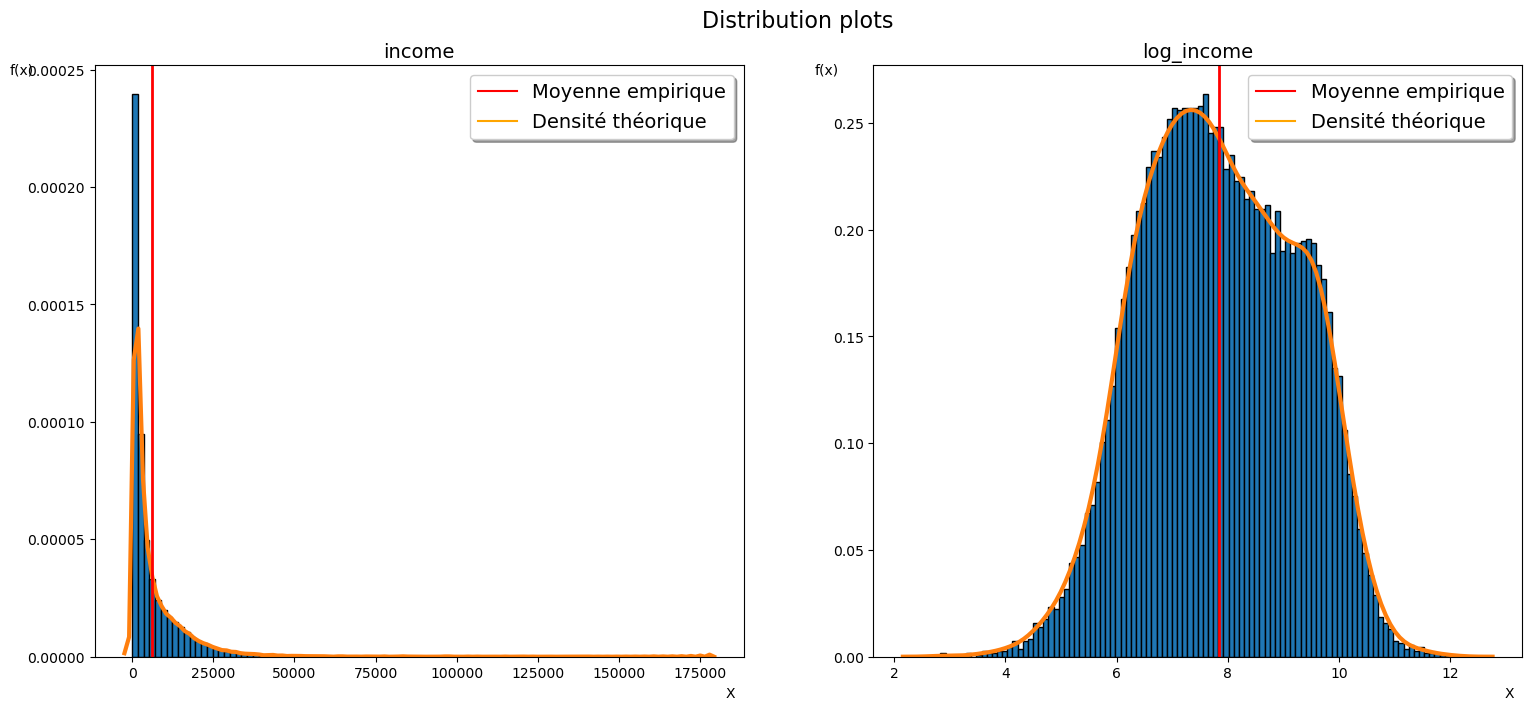

In [86]:
VAR_1 =  anova_vnorm['income']
VAR_2 =  anova_vln['log_income']

plt.subplots(figsize=(15,7))
plt.suptitle("Distribution plots", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# -----------------------------------------------------------------------------------Tracé histo + moyenne + densité gaussienne
plt.subplot(1, 2, 1)
sns.distplot(VAR_1, bins=100,kde_kws={"color": "tab:orange", "lw": 3},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"})
plt.axvline(np.mean(VAR_1), color='r', linewidth=2)
import matplotlib.lines as mlines
colors = {'Moyenne empirique':'red', 'Densité théorique':'orange'}         
labels = list(colors.keys())
handles = [mlines.Line2D([], [], color=colors[label]) for label in labels] 
plt.legend(handles, labels, ncol=1, shadow=True, loc='upper right',fontsize=14)
plt.title(str(VAR_1.name), fontsize=14)
plt.xlabel("X", position=(0.98,0))
plt.ylabel("f(x)", position=(0,0.98),rotation = 0)

# -----------------------------------------------------------------------------------Tracé histo + moyenne + densité gaussienne
plt.subplot(1, 2, 2)
sns.distplot(VAR_2, bins=100,kde_kws={"color": "tab:orange", "lw": 3},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"})
plt.axvline(np.mean(VAR_2), color='r', linewidth=2)
plt.legend(handles, labels, ncol=1, shadow=True, loc='upper right',fontsize=14)
plt.title(str(VAR_2.name), fontsize=14)
plt.xlabel("X", position=(0.98,0))
plt.ylabel("f(x)", position=(0,0.98),rotation = 0)
plt.ticklabel_format(useOffset=False, style='plain')

plt.savefig('OUTPUTS_FORMATION/P7_Distributions_Gauss.jpg',dpi=100)
plt.show()

**<div class="alert alert-info" role="alert">
<font color='k'> La bimodalité (i.e 2 modes ou 2 pics) d'une distribution dans un échantillon est souvent une indication forte du fait que la distribution de la variable dans la population n'est pas normale.
</font></div>**

## Vérification hypothèse de normalité : QQ-plots

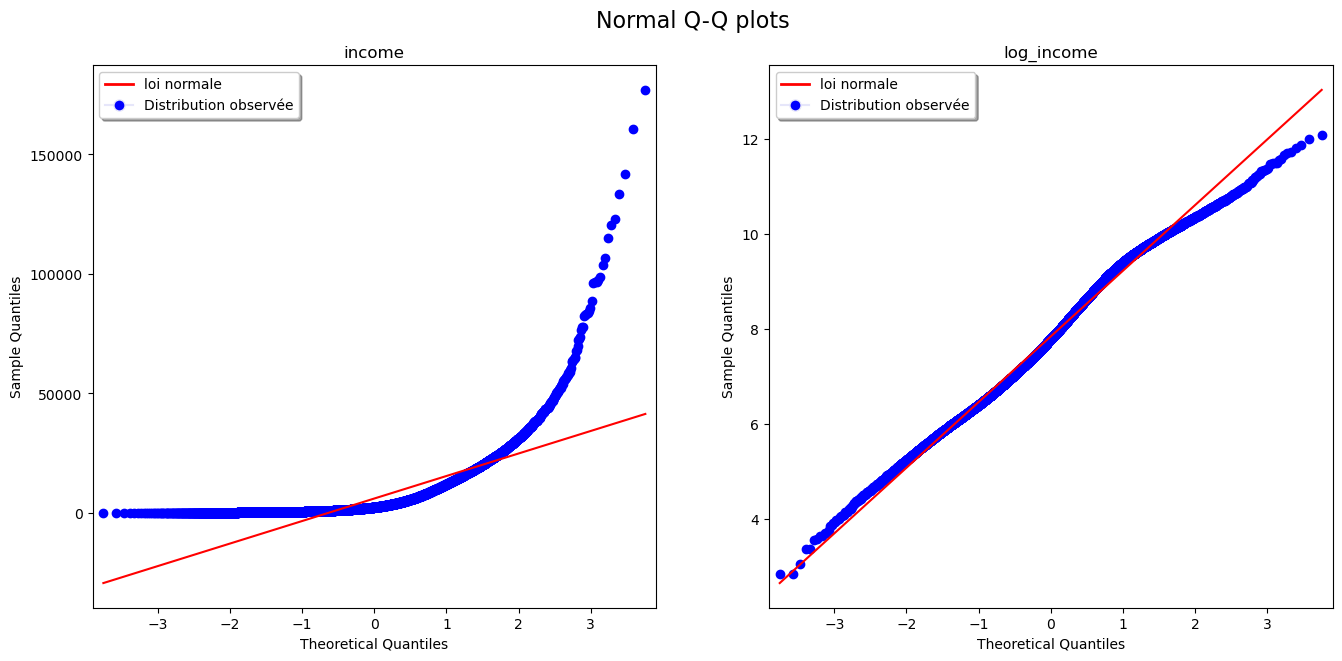

In [87]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import statsmodels.api as sm

fig = plt.figure(figsize=(16, 7))
plt.suptitle("Normal Q-Q plots", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# -----------------------------------------------------------------------------------Tracé QQplots
ax = fig.add_subplot(1, 2, 1)
sm.graphics.qqplot(VAR_1, line='s', ax=ax, color='blue')
plt.title(str(VAR_1.name),fontsize=12)
plt.xlabel("Theoretical Quantiles",fontsize=10)
plt.ylabel("Sample Quantiles",fontsize=10)
plt.grid(color='w', linestyle='-', linewidth=1)
plt.grid(True)
legend_elements = [Line2D([0], [0], color='red', lw=2, label='loi normale'),
                   Line2D([0], [0], marker='o', color='lavender', label='Distribution observée',markerfacecolor='blue', markersize=8),
                  ]
ax.legend(handles=legend_elements, loc='upper left',shadow=True)

# -----------------------------------------------------------------------------------Tracé QQplots
ax = fig.add_subplot(1, 2, 2)
sm.graphics.qqplot(VAR_2, line='s', ax=ax, color='blue')
plt.title(str(VAR_2.name),fontsize=12)
plt.xlabel("Theoretical Quantiles",fontsize=10)
plt.ylabel("Sample Quantiles",fontsize=10)
plt.grid(color='w', linestyle='-', linewidth=1)
ax.legend(handles=legend_elements, loc='upper left',shadow=True)

plt.savefig('OUTPUTS_FORMATION/P7_QQplots.jpg',dpi=300)
plt.show()

**<div class="alert alert-info" role="alert">
<font color='k'> La version en log(revenus) se rapproche nettement plus de la loi normale.
</font></div>**

## Vérification hypothèse de normalité : Test Shapiro-Wilk

In [88]:
# obj: NE PAS REJETER Ho (la var a une distribution normale dans la population)
# En pratique, on cherche à limiter le risque de se tromper en obtenant une p_value>0.20 (ne pas se contenter de p_value>0.05)
from scipy import stats as st  
x=[VAR_1, VAR_2]
# x=[VAR_1.drop_duplicates(), VAR_2.drop_duplicates()]

p_value    =[]
W_statistic=[]
statut_norm=[]
for i in x: 
    shap=st.shapiro(i)
    print(shap)
    print('\x1b[6;33;40m',f"{'W test statistic = ' : <10}{round(st.shapiro(i).statistic,3)}",'\x1b[0m')
    print('\x1b[6;33;40m',f"{'p-value          = ' : <10}{round(st.shapiro(i).pvalue,5)}",'\x1b[0m')
    if shap.pvalue > 0.05 :
        print('\x1b[6;32;40m',"Avec une p_value > 5%, on accepte l’hypothèse de normalité (Ho). \n On peut considérer que la variable "+str(i.name.upper())+" suit une distribution normale.",'\x1b[0m')
    else :
        print('\x1b[6;31;40m',"Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). \n On peut considérer que la variable "+str(i.name.upper())+" ne suit pas une distribution normale.",'\x1b[0m')
    print('')
    W_statistic.append(shap.statistic)
    p_value.append(shap.pvalue)
    if shap.pvalue > 0.05:
        statut_norm.append("normal")
    else :
        statut_norm.append("#")
results = [W_statistic,p_value,statut_norm]
index   = ['W_statistic','p_value','Normality']
columns = [VAR_1.name, VAR_2.name]
df_Shapiro = pd.DataFrame(data=results, index=index, columns=columns)

def custom_style1(row):
    color = 'white'
    if row.values[2] == '#':
        color = 'lightcoral'
    else:
        color = 'limegreen'
    return ['background-color: %s' % color]*len(row.values)
df_Shapiro.style.apply(custom_style1, axis=0)   

ShapiroResult(statistic=0.5987718105316162, pvalue=0.0)
 W test statistic = 0.599 
 p-value          = 0.0 
 Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). 
 On peut considérer que la variable INCOME ne suit pas une distribution normale. 

ShapiroResult(statistic=0.9917111992835999, pvalue=2.2970298357258303e-25)
 W test statistic = 0.992 
 p-value          = 0.0 
 Avec une p_value << 5%, on ne peut pas retenir l’hypothèse de normalité (Ho). 
 On peut considérer que la variable LOG_INCOME ne suit pas une distribution normale. 



**<div class="alert alert-info" role="alert">
<font color='k'> Comme pressenti sur les distributions gaussiennes, le test de Shapiro-Wilk rejette l'hypothèse selon laquelle la variable (sous ses 2 formes) suit une distribution normale (cf. bi-modalité).
Pour la suite, on ne conservera donc que la version de la variable LOG se rapprochant le plus d'une loi normale.
</font></div>**

## ANOVA bivariée : Var à expliquer = log(revenus) et Var explicative = Pays

Le η2 s’interprétera toujours de la même façon :

η2 = SSbetween / SStotal = SSB / SST
   = proportion of variance in Y explained by X
   = squared non-linear corr coeff
   = R²
   = intensité de la corrélation
   
η2 ranges between 0 and 1.

En règle générale : 0.01 ~ small , 0.06 ~ medium > , 0.14 ~ large

In [89]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.tools import add_constant

In [90]:
anova_vln = sm.tools.add_constant(anova_vln)
X = "log_income"
Y = "Country_Code"
# Ordinary Least Squares regression
# 1st fit linéaire (ite 1)
model_0 = ols('log_income ~ Country_Code', data=anova_vln).fit()              
aov_table = sm.stats.anova_lm(model_0, typ=2)
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0] + aov_table['sum_sq'][1])
aov_table['EtaSq'] = [esq_sm, 'NaN']
print('\x1b[6;30;44m',X.upper(),'vs',Y.upper(),'\x1b[0m')
print(aov_table)
print('\x1b[6;31;40m',f"{'F statistic               = ' : <10}{round(aov_table['F'][0],0)}",'\x1b[0m')
print('\x1b[6;31;40m',f"{'p-value for F statistics  = ' : <10}{aov_table['PR(>F)'][0]}",'\x1b[0m')
print('\x1b[6;31;40m',f"{'η2                        = ' : <10}{round(aov_table['EtaSq'][0],3)}",'\x1b[0m')
print('\x1b[6;33;40m',"Avec un F >> 1 and p_value (PR(>F)) < 5%, on peut donc rejeter l’hypothèse d'égalité des moyennes (Ho). \n On peut considérer que la variable ",str(Y)," influe sur ",str(X),'\x1b[0m')

 LOG_INCOME vs COUNTRY_CODE 
                    sum_sq       df           F  PR(>F)     EtaSq
Country_Code  16134.136079    115.0  268.953709     0.0  0.729238
Residual       5990.506186  11484.0         NaN     NaN       NaN
 F statistic               = 269.0 
 p-value for F statistics  = 0.0 
 η2                        = 0.729 
 Avec un F >> 1 and p_value (PR(>F)) < 5%, on peut donc rejeter l’hypothèse d'égalité des moyennes (Ho). 
 On peut considérer que la variable  Country_Code  influe sur  log_income 


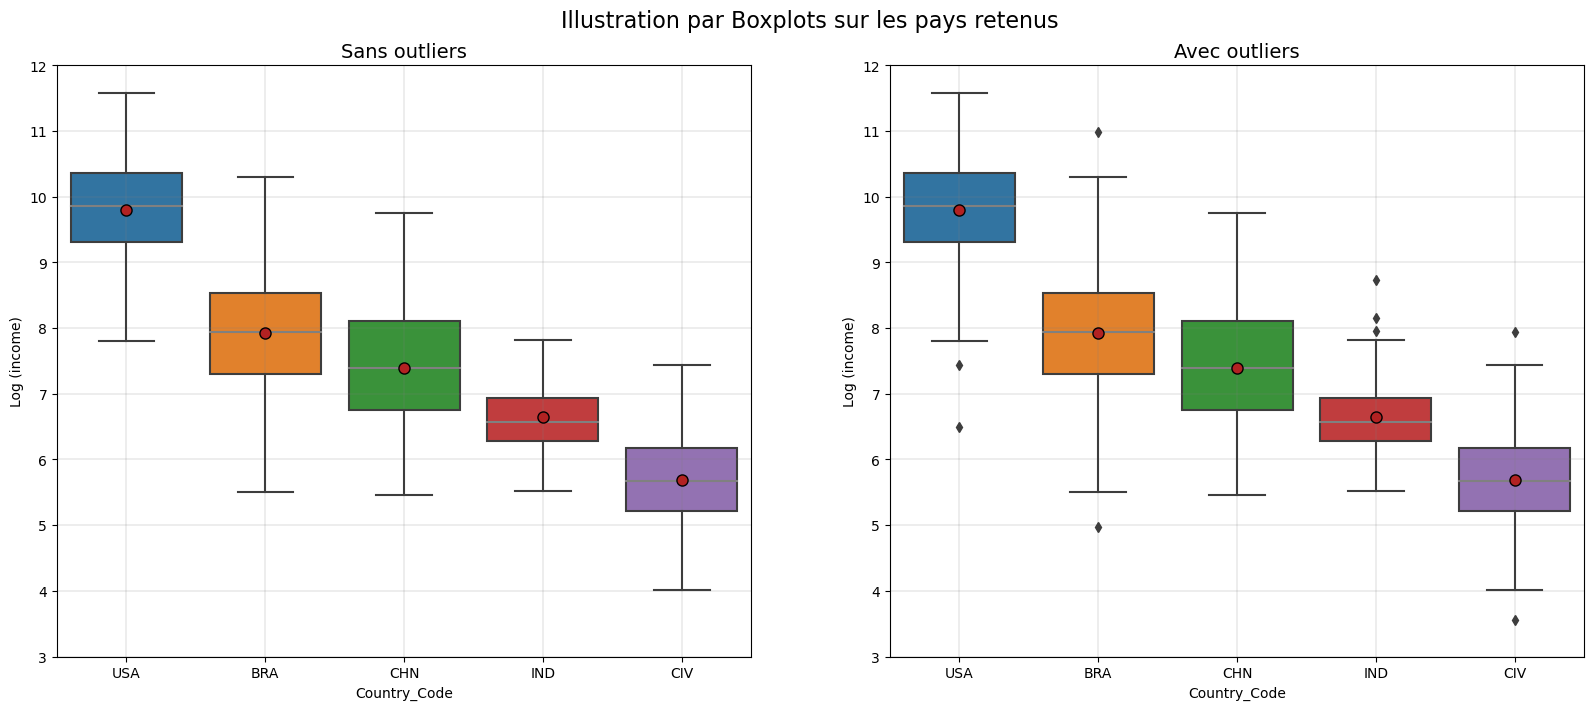

In [91]:
df_pays_box = df_rech_quantile_quar.query('Country_Code == ["BRA","CHN","USA","IND","CIV"]', inplace=False) 

# Visualisation Boxplot des valeurs income par pays
plt.subplots(figsize=(16,7))
plt.suptitle("Illustration par Boxplots sur les pays retenus", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# my_order = df.groupby(by=["species"])["sepal_length"].median().iloc[::-1].index
medianprops = {'color':"grey"}
meanprops   = {'marker':'o','markeredgecolor':'black','markerfacecolor':'firebrick','ms':8}

plt.subplot(1, 2, 1)
sns.boxplot(data=df_pays_box, x='Country_Code', y=np.log(df_pays_box['income']), showmeans=True, meanprops=meanprops, showfliers=False, medianprops=medianprops, order=["USA","BRA","CHN","IND","CIV"])
plt.title("Sans outliers", fontsize=14)
plt.ylabel("Log (income)")
plt.ylim(3,12)
plt.grid(color='gray', linestyle='-', linewidth=0.2)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_pays_box, x='Country_Code', y=np.log(df_pays_box['income']), showmeans=True, meanprops=meanprops, showfliers=True, medianprops=medianprops, order=["USA","BRA","CHN","IND","CIV"])
plt.title("Avec outliers", fontsize=14)
plt.ylabel("Log (income)")
plt.ylim(3,12)
plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.savefig('OUTPUTS_FORMATION/P7_Boxplot_log.jpg',dpi=300)
plt.show()

In [92]:
print('\x1b[6;32;40m',"Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var):", str(100*round(model_0.rsquared_adj,3)),"%",'\x1b[0m')
print(model_0.summary())

 Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var): 72.7 % 
                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     269.0
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:42:30   Log-Likelihood:                -12627.
No. Observations:               11600   AIC:                         2.549e+04
Df Residuals:                   11484   BIC:                         2.634e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

RAPPEL : p-value of 0.691, means there's a 69.1% chance that this was just random fluctuations in the data, and nothing meaningful

### Aller plus loin, itération 2 après élimination valeurs (pvalue > 5%)

In [93]:
# création d'un df regroupant les infos importantes du bloc summary
coefs = pd.DataFrame({
                        'coef': model_0.params.values,
                        'odds ratio': np.exp(model_0.params.values),
                        'pvalue': model_0.pvalues,
                        'name': model_0.params.index
                    }).sort_values(by='pvalue', ascending=False)
coefs['name'] = coefs['name'].str.replace("Country_Code", "")
coefs['name'] = coefs['name'].str.replace("[", "")
coefs['name'] = coefs['name'].str.replace("]", "")
coefs['name'] = coefs['name'].str.replace("T.", "")
pvalue_lim = 0.05
for i in range (len(coefs)):
    if model_0.pvalues[i] > pvalue_lim:
#         print('\x1b[6;31;40m','!/ PROBLEM /!' + coefs.name + ' reach ' + str(pvalue_lim),'\x1b[0m')
        print('\x1b[6;31;40m','!/ Degrés de significativité /!','\x1b[0m')

 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 
 !/ Degrés de significativité /! 


In [94]:
# afin d'améliorer notre modèle, on stocke les variables où pvalues > 5%
TB_discarded = coefs[coefs['pvalue'] > 0.05]

# nv df la prochaine régression en écartant les valeurs précédentes
anova_vln = anova_vln[~anova_vln['Country_Code'].isin(TB_discarded['name'])]

# 2d fit linéaire (ite 2)
model_0bis = ols('log_income ~ Country_Code', data=anova_vln).fit()
print('\x1b[6;32;40m',"Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var):", str(100*round(model_0bis.rsquared_adj,3)),"%",'\x1b[0m')
print(model_0bis.summary())
# print(model.summary().tables[0]) # affichage sans coefficients

 Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var): 75.5 % 
                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     311.5
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:42:30   Log-Likelihood:                -11237.
No. Observations:               10600   AIC:                         2.269e+04
Df Residuals:                   10494   BIC:                         2.346e+04
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

### Analyse de la performance

**<div class="alert alert-info" role="alert">
<font color='k'> Pour cette 1ère ANOVA (log(rev)=f(pays)), la statistique de Fisher est >> 1 avec une intensité de la corrélation η2 > 0,7. La variable "Country_Code" influe de façon évidente sur la variable "log(income)". 
Accessoirement, dans le cadre de la régression linéaire, on observe le passage d'un premier modèle expliquant 73% de la variance à un modèle amélioré expliquant 76%, soit un gain de 3%.
</font></div>**

## ANOVA multivariée : log(rev) = f(rev moyen pays + GINI pays de l’ind)

### Régression multilinéaire 1

In [95]:
# calcul revenu moyen et indice de GINI moyens par pays
anova_multi = Sample_final.groupby(['Country_Code']).agg({'income':'mean','GINI_avg':'mean'}).round(1)
anova_multi.rename(columns={'income':'income_mean','GINI_avg':'GINI_mean'}, inplace=True)

# merge de ces 2 var moyennées au df principal
Sample_regmulti1 = Sample_final.merge(anova_multi, how='left', left_on='Country_Code', right_index=True)

# préparation des données pour la prochaine régression
anova_vnorm = Sample_regmulti1[['income','income_mean','GINI_mean']].drop_duplicates()
anova_vln = Sample_regmulti1[['income','income_mean','GINI_mean']].drop_duplicates()
anova_vln['income'] = np.log(anova_vnorm['income'])
anova_vln['income_mean'] = np.log(anova_vln['income_mean'])

anova_vln.columns=['log_income','log_income_mean','GINI_mean']

# copy du df
copy_df = anova_vln.copy()

# reg multilinéaire
model_multi1 = ols('log_income ~ log_income_mean + GINI_mean', data=copy_df).fit()
print('\x1b[6;32;40m',"Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var):", str(100*round(model_multi1.rsquared_adj,2)),"%",'\x1b[0m')
print(model_multi1.summary())

 Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var): 73.0 % 
                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                 1.546e+04
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:42:33   Log-Likelihood:                -12670.
No. Observations:               11600   AIC:                         2.535e+04
Df Residuals:                   11597   BIC:                         2.537e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### Décomposition de la variance

                       sum_sq       df             F        PR(>F)     EtaSq
log_income_mean  13334.715857      1.0  25622.424988  0.000000e+00  0.681609
GINI_mean          193.415263      1.0    371.644069  1.538849e-81  0.009886
Residual          6035.443556  11597.0           NaN           NaN  0.308504


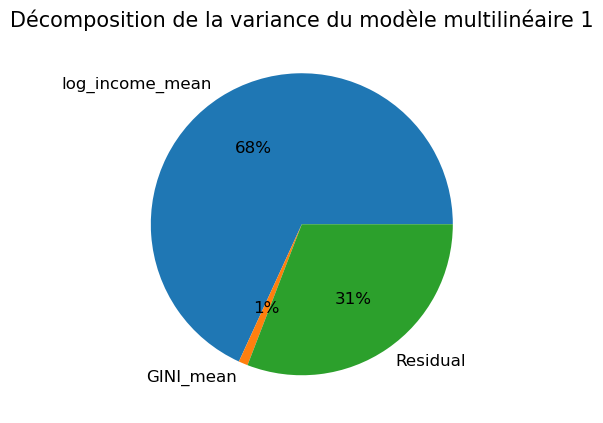

In [96]:
aov_table = sm.stats.anova_lm(model_multi1, typ=2)
Sum_Sq = aov_table['sum_sq'][0] + aov_table['sum_sq'][1]+ aov_table['sum_sq'][2]
esq_sm1 = aov_table['sum_sq'][0]/Sum_Sq
esq_sm2 = aov_table['sum_sq'][1]/Sum_Sq
esq_sm3 = aov_table['sum_sq'][2]/Sum_Sq
aov_table['EtaSq'] = [esq_sm1, esq_sm2, esq_sm3]
print(aov_table)
aov_table['EtaSq'].plot.pie(autopct='%1.f%%',fontsize=12)
plt.title("Décomposition de la variance du modèle multilinéaire 1",fontsize=15)
plt.ylabel('')
plt.savefig('OUTPUTS_FORMATION/P7_décomposition_Variance_mdl1.jpg',dpi=300)
plt.show()

### Normalité des résidus

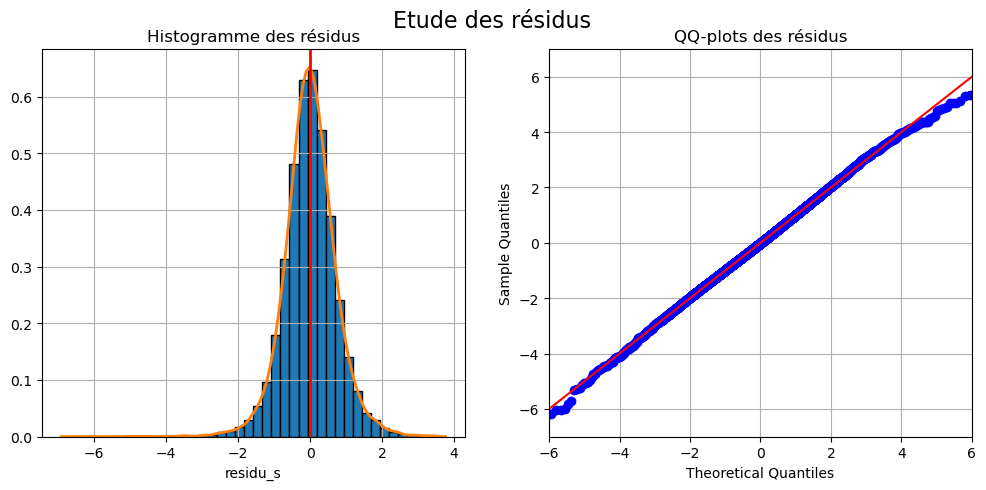

ShapiroResult(statistic=0.9783838391304016, pvalue=1.7998681049745676e-38)
 Par le test de Shapiro-Wilk, avec une p_value << 5% on ne peut pas retenir l’hypothèse de normalité (Ho) 
La forme de la distribution est à 98% similaire à une loi normale, mais elle n'est pas homogène selon la pvalue


In [97]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Etude des résidus", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1)
copy_df['residu_s'] = model_multi1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(copy_df['residu_s'], bins=40,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(copy_df['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_multi1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.ylim(-7,7)
plt.xlim(-6,6)
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P7_normalité_residus.jpg',dpi=300)
plt.show()

print(st.shapiro(model_multi1.resid))
print('\x1b[6;31;40m',"Par le test de Shapiro-Wilk, avec une p_value << 5% on ne peut pas retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print("La forme de la distribution est à 98% similaire à une loi normale, mais elle n'est pas homogène selon la pvalue")

<div class="alert alert-info" role="alert">
<font color='k'> 
Kurtosis : coefficient d’aplatissement, dans le cas d’une loi normale, il est égal à 3. 
Un kurtosis élevé indique que la distribution est plutôt pointue.
À l'opposé, un kurtosis proche de zéro indique une distribution relativement aplatie pour une même variance.</font></div>


<div class="alert alert-info" role="alert">
<font color='k'> 
Skewness : mesure de la symétrie.
Highly skewed distribution: If -1 < skewness < +1, 
Moderately skewed distribution: If −1 < skewness < −½ ou +½ < skewness < +1, 
Approximately symmetric distribution: If −½ < skewness < +½</font></div>

In [98]:
print("Kurtosis (should be 3 for normal distribution): ",pd.DataFrame(model_multi1.resid).kurtosis()[0].round(2))
# print(st.kurtosis(model_multi1.resid, bias=False))
print("Skewness (should be [−½; ½] for symmetrical distribution): ",pd.DataFrame(model_multi1.resid).skew()[0].round(2))
# print(st.skew(model_multi1.resid, bias=False))

Kurtosis (should be 3 for normal distribution):  2.72
Skewness (should be [−½; ½] for symmetrical distribution):  -0.13


### Homoscédasticité des résidus

In [99]:
variables = model_multi1.model.exog
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(model_multi1.resid, variables)
print('p value test Breusch Pagan:', pval)
print('\x1b[6;31;40m',"Avec une p_value < 5%, on peut considérer que les résidus ne sont pas homoscédastiques (i.e. ne présentant pas la même variance)",'\x1b[0m')

p value test Breusch Pagan: 4.82519082759622e-127
 Avec une p_value < 5%, on peut considérer que les résidus ne sont pas homoscédastiques (i.e. ne présentant pas la même variance) 


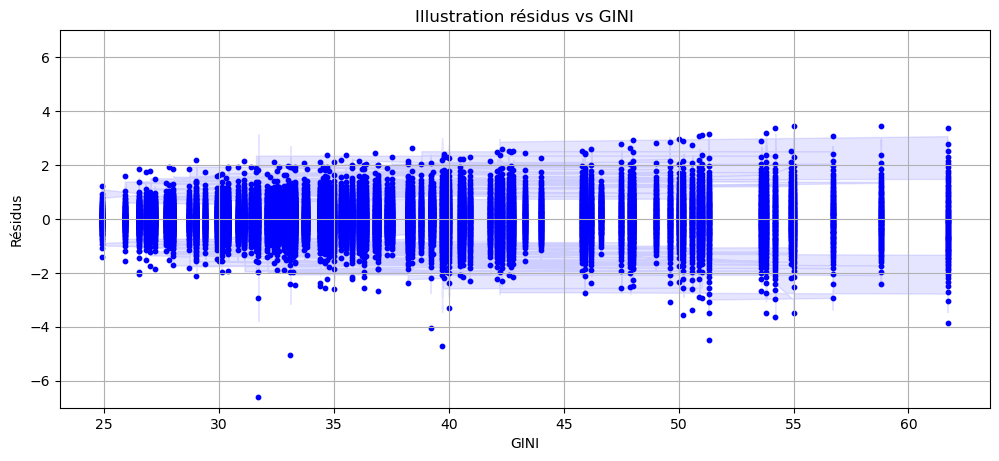

In [100]:
plt.scatter(copy_df['GINI_mean'], model_multi1.resid,c='b',s=10)

#Declare the array containing the series you want to plot. 
time_series_array = model_multi1.resid
n_steps           = 20 
time_series_df = pd.DataFrame(time_series_array)
smooth_path    = time_series_df.rolling(n_steps).mean()
path_deviation = time_series_df.rolling(n_steps).std()
plt.fill_between(copy_df['GINI_mean'],(smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1) #std curves.

plt.grid()
plt.ylim(-7,7)
# plt.xlim(-6,6)
plt.xlabel("GINI",fontsize=10)
plt.ylabel("Résidus",fontsize=10)
plt.title("Illustration résidus vs GINI",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P7_illus_homoscéd_residus.jpg',dpi=300)
plt.show()

### Corrélation et colinéarité des variables

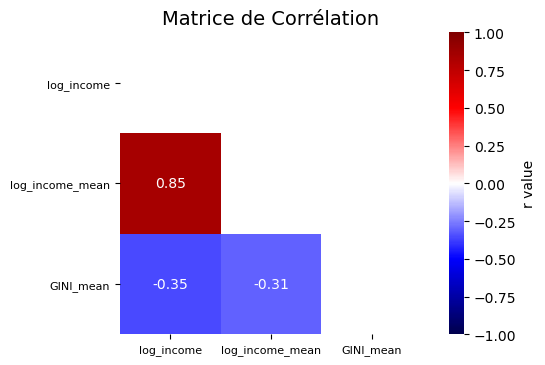

Comme attendu, forte corrélation entre variables log_income et log_income_mean


In [101]:
copy_df.drop(columns=['residu_s'], inplace=True)
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':100})
corrMatrix = copy_df.corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrMatrix, cmap='seismic',fmt='.2f',mask=mask, square=True, vmin=-1, vmax=1,
            cbar_kws={'label': 'r value'},annot=corrMatrix.iloc[:,:])
plt.title("Matrice de Corrélation",fontsize=14)
plt.xticks(rotation = 0,fontsize=8)
plt.yticks(rotation = 0,fontsize=8)
plt.savefig('OUTPUTS_FORMATION/P7_Correlation_matrix_mdl1.jpg',dpi=300)
plt.show()
print("Comme attendu, forte corrélation entre variables log_income et log_income_mean")

In [102]:
# analyse de la colinéartité
def get_vif(exogs, data):
    '''Args:
        exogs (list): list of exogenous/independent variables
        data (DataFrame): the df storing all variables
    Returns:
        Variation Inflation Factors and Tolerance DataFrame for each exogenous variable
    Notes:
        Assume we have a list of exogenous variable [X1, X2, X3, X4]. 
        To calculate the VIF and Tolerance for each variable, we regress each of them against other exogenous variables. 
        For instance, the regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
        And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
                    Tolerance = 1 - R-squared
        The cutoff to detect multicollinearity:
                    VIF > 10 or Tolerance < 0.1'''

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

exogs = ['log_income_mean','GINI_mean']
print('\x1b[6;31;40m',"Pas de colinéarité entre les variables",'\x1b[0m')
get_vif(exogs=exogs, data=copy_df)

 Pas de colinéarité entre les variables 


VIF  Tolerance
log_income_mean  1.107423   0.902997
GINI_mean        1.107423   0.902997

In [103]:
# Autre méthode
'''Lecture des VIF sur la diagonale principale de la matrice inverse de la matrice des corrélations'''
diag_df = copy_df[['log_income_mean','GINI_mean']]
vif = pd.Series(np.linalg.inv(diag_df.corr().to_numpy()).diagonal(),index=diag_df.columns, name='VIF')
vif

log_income_mean    1.107423
GINI_mean          1.107423
Name: VIF, dtype: float64

Variance [F1, F2] = [0.66409981 0.33590019]


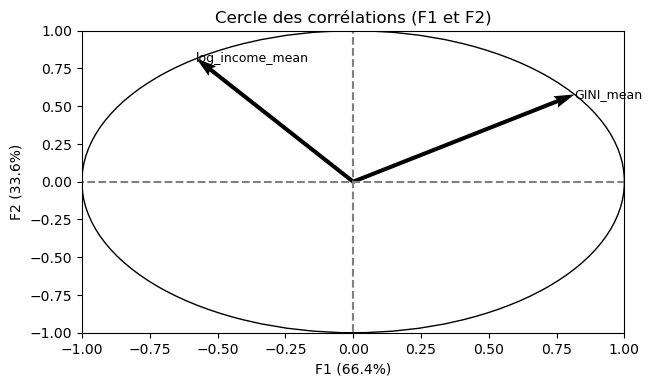

In [104]:
# Autre méthode visuelle avec ACP
# Choix du nombre de composantes à calculer
n_comp = 2 # Nbmaxi = Min(p,n-1) = Min(7,170-1)

# selection des colonnes à prendre en compte dans l'ACP
data_pca = copy_df[['log_income_mean','GINI_mean']]

# préparation des données pour l'ACP
# data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X        = data_pca.values
names    = list(data_pca.index)
features = data_pca.columns

# Centrage et Réduction
# std_scale = preprocessing.StandardScaler().fit(X)     #Compute the mean and std to be used for later scaling
std_scale = preprocessing.RobustScaler().fit(X)         #Removes the median and scales the data according to the quantile range
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Projection des individus
X_projected = pca.transform(X_scaled)

print('Variance [F1, F2] =',pca.explained_variance_ratio_)
# X_trans=pca.transform(X_scaled)

# Cercle des corrélations
pcs = pca.components_

# Adaptation de la fonction pr obtention 2 infos sur le même tracé (ajout scale factor pour les corrélations)
display_circles(X_projected,pcs, n_comp, pca, [(0,1)], labels = np.array(features), illustrative_var=clusters,alpha=1)
plt.savefig('OUTPUTS_FORMATION/P7_ACP_mdl1.jpg',dpi=100)
plt.show()

### Calcul des leviers

*Un effet de levier (Hi) mesure la distance entre la valeur de X d'une observation et la moyenne des valeurs de X de toutes les observations d'un ensemble de données. Les observations à fort effet de levier peuvent avoir un effet important sur la valeur ajustée et, par conséquent, sur le modèle de régression.*

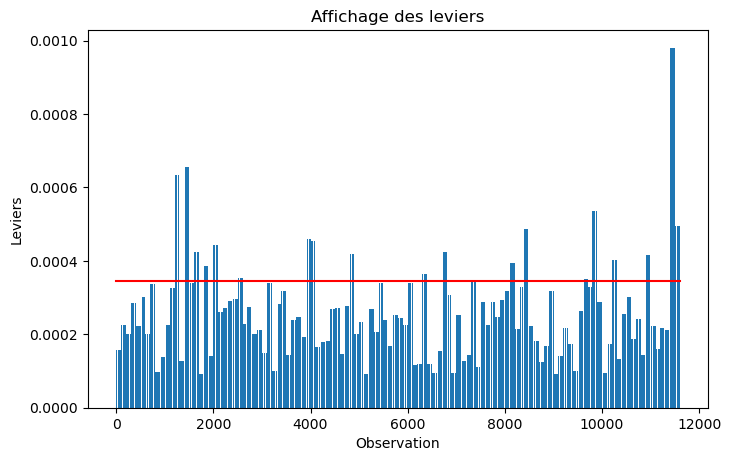

obs    levier
1200    1201  0.000634
1201    1202  0.000634
1202    1203  0.000634
1203    1204  0.000634
1204    1205  0.000634
...      ...       ...
11595  11596  0.000495
11596  11597  0.000495
11597  11598  0.000495
11598  11599  0.000495
11599  11600  0.000495

[2000 rows x 2 columns]

In [105]:
# analyse des pts influents
infl = model_multi1.get_influence()
n = copy_df.shape[0]
p = 2 #nb var explicatives
alpha = 0.05
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['levier'] = infl.hat_matrix_diag
seuil_levier = 2*p/n

plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
plt.bar(analyses['obs'], analyses['levier'])
plt.title("Affichage des leviers",fontsize=12)
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.savefig('OUTPUTS_FORMATION/P7_Leviers.jpg',dpi=300)
plt.show()

# identification des observations où levier > seuil (2p/n)
analyses.loc[analyses['levier'] > seuil_levier, :]

### Distance de Cook

*Géométriquement, la distance de Cook est une mesure de la distance entre les valeurs ajustées calculées avec et sans la ième observation. Elle permet d'identifier les observations présentant des valeurs de prédicteurs aberrantes par rapport au reste des données, ainsi que les observations auxquelles le modèle n'est pas correctement ajusté. Les observations présentant de grandes distances de Cook peuvent avoir un effet important sur la valeur ajustée et, par conséquent, sur le modèle de régression.*

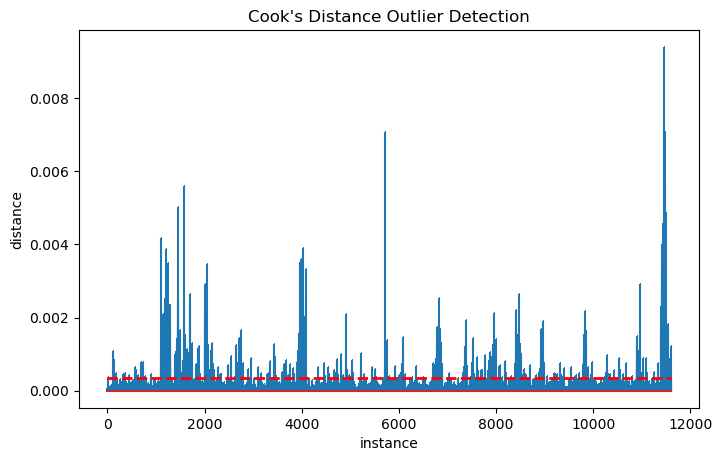

 Nb of outliers (d > seuil=4/n) :  669
 Outliers with highest d > 0.004  :   [ 1110  1459  1569  5710 11416 11430 11449 11476 11486 11498]

It’s important to note that Cook’s Distance should be used as a way to identify potentially influential observations. Just because an observation is influential doesn’t necessarily mean that it should be deleted from the dataset.First, you should verify that the observation isn’t a result of a data entry error or some other odd occurrence. If it turns out to be a legit value, you can then decide if it’s appropriate to delete it, leave it be, or simply replace it with an alternative value like the median.


In [106]:
# Distance de Cook
sm_fr = infl.summary_frame()
C, P = infl.cooks_distance
n = copy_df.shape[0]
seuil_DistCook = 4/n

def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(8,5))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax

plot_cooks_distance(C)
plt.plot([0, n], [seuil_DistCook, seuil_DistCook], color='r', ls='--', lw=2)      
plt.savefig('OUTPUTS_FORMATION/P7_Distance_Cook.jpg',dpi=300)
plt.show()

print('\x1b[6;31;40m',"Nb of outliers (d > seuil=4/n) :",'\x1b[0m',len(np.where(sm_fr.cooks_d > seuil_DistCook)[0]))
print('\x1b[6;31;40m',"Outliers with highest d > 0.004  : ",'\x1b[0m',np.where(sm_fr.cooks_d>0.004)[0])
print('')
print("It’s important to note that Cook’s Distance should be used as a way to identify potentially influential observations. Just because an observation is influential doesn’t necessarily mean that it should be deleted from the dataset.First, you should verify that the observation isn’t a result of a data entry error or some other odd occurrence. If it turns out to be a legit value, you can then decide if it’s appropriate to delete it, leave it be, or simply replace it with an alternative value like the median.")

**<div class="alert alert-info" role="alert">
<font color='k'> Perpectives : étudier et écarter les valeurs si besoin, le tout dans le but d'améliorer le model, 
df.drop(df.index[[...,...,...,...]]) + relance régression
</font></div>**

## ANOVA multivariée : log(rev) = f(rev moy pays + GINI pays de l’ind + classe parents)

### Régression multilinéaire 2

In [107]:
Sample_regmulti1 = Sample_regmulti1[['income','income_mean','GINI_mean','c_i_parent']]
Sample_regmulti1['income'] = np.log(Sample_regmulti1['income'])
Sample_regmulti1['income_mean'] = np.log(Sample_regmulti1['income_mean'])
Sample_regmulti1.columns=['log_income','log_income_mean','GINI_mean','classe_parent']

# copy du df
copy_df_2 = Sample_regmulti1.copy()

# reg multilinéaire
model_multi2 = ols('log_income ~ log_income_mean + GINI_mean + classe_parent', data=copy_df_2).fit()
print('\x1b[6;32;40m',"Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var):", str(100*round(model_multi2.rsquared_adj,2)),"%",'\x1b[0m')
print(model_multi2.summary())

 Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var): 77.0 % 
                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                 6.619e+06
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:43:29   Log-Likelihood:            -5.7856e+06
No. Observations:             5800000   AIC:                         1.157e+07
Df Residuals:                 5799996   BIC:                         1.157e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### Décomposition de la variance

                       sum_sq         df             F  PR(>F)     EtaSq
log_income_mean  6.607891e+06        1.0  1.534981e+07     0.0  0.679067
GINI_mean        9.767929e+04        1.0  2.269042e+05     0.0  0.010038
classe_parent    5.284476e+05        1.0  1.227558e+06     0.0  0.054306
Residual         2.496822e+06  5799996.0           NaN     NaN  0.256589


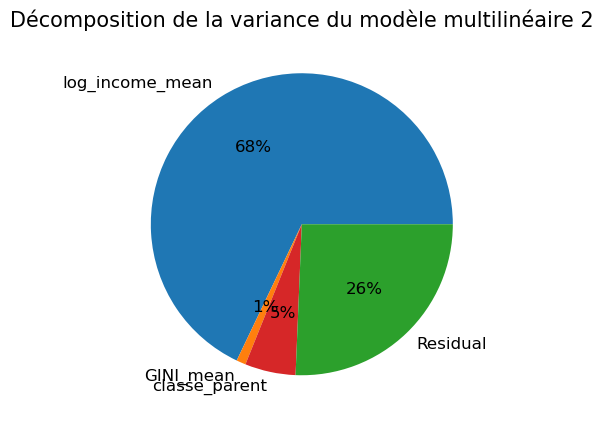

In [108]:
aov_table = sm.stats.anova_lm(model_multi2, typ=2)
Sum_Sq = aov_table['sum_sq'][0] + aov_table['sum_sq'][1] + aov_table['sum_sq'][2] + aov_table['sum_sq'][3]
esq_sm1 = aov_table['sum_sq'][0]/Sum_Sq
esq_sm2 = aov_table['sum_sq'][1]/Sum_Sq
esq_sm3 = aov_table['sum_sq'][2]/Sum_Sq
esq_sm4 = aov_table['sum_sq'][3]/Sum_Sq
aov_table['EtaSq'] = [esq_sm1, esq_sm2, esq_sm3, esq_sm4]
print(aov_table)
mycolors = ['tab:blue','tab:orange','tab:red','tab:green']
aov_table['EtaSq'].plot.pie(autopct='%1.f%%',fontsize=12,colors = mycolors)
plt.title("Décomposition de la variance du modèle multilinéaire 2",fontsize=15)
plt.ylabel('')
plt.savefig('OUTPUTS_FORMATION/P7_décomposition_Variance_mdl2.jpg',dpi=300)
plt.show()

### Normalité des résidus

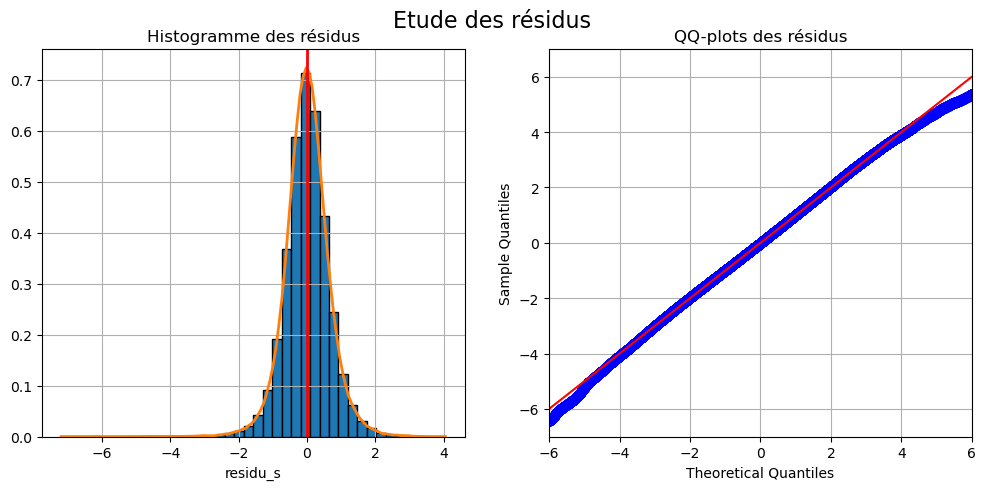

ShapiroResult(statistic=0.9757068753242493, pvalue=0.0)
 Par le test de Shapiro-Wilk, avec une p_value << 5% on ne peut pas retenir l’hypothèse de normalité (Ho) 
La forme de la distribution est à 98% similaire à une loi normale, mais elle n'est pas homogène selon la pvalue


In [109]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Etude des résidus", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1)
copy_df_2['residu_s'] = model_multi2.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(copy_df_2['residu_s'], bins=40,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(copy_df_2['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_multi2.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.ylim(-7,7)
plt.xlim(-6,6)
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P7_normalité_residus_mdl2.jpg',dpi=300)
plt.show()

print(st.shapiro(model_multi2.resid))
print('\x1b[6;31;40m',"Par le test de Shapiro-Wilk, avec une p_value << 5% on ne peut pas retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print("La forme de la distribution est à 98% similaire à une loi normale, mais elle n'est pas homogène selon la pvalue")

In [110]:
print("Kurtosis (should be 3 for normal distribution): ",pd.DataFrame(model_multi2.resid).kurtosis()[0].round(2))
# print(st.kurtosis(model_multi1.resid, bias=False))
print("Skewness (should be [−½; ½] for symmetrical distribution): ",pd.DataFrame(model_multi2.resid).skew()[0].round(2))
# print(st.skew(model_multi1.resid, bias=False))

Kurtosis (should be 3 for normal distribution):  3.04
Skewness (should be [−½; ½] for symmetrical distribution):  -0.18


### Homoscédasticité des résidus

In [111]:
variables = model_multi2.model.exog
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(model_multi2.resid, variables)
print('p value test Breusch Pagan:', pval)
print('\x1b[6;31;40m',"Avec une p_value < 5%, on peut considérer que les résidus ne sont pas homoscédastiques (i.e. ne présentant pas la même variance)",'\x1b[0m')

p value test Breusch Pagan: 0.0
 Avec une p_value < 5%, on peut considérer que les résidus ne sont pas homoscédastiques (i.e. ne présentant pas la même variance) 


### Corrélation et colinéarité des variables

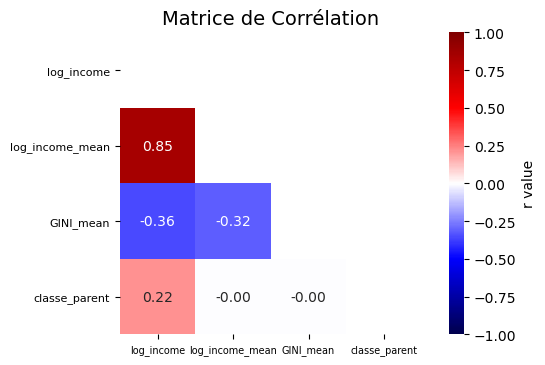

In [112]:
copy_df_2.drop(columns=['residu_s'], inplace=True)
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':100})
corrMatrix = copy_df_2.corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrMatrix, cmap='seismic',fmt='.2f',mask=mask, square=True, vmin=-1, vmax=1,
            cbar_kws={'label': 'r value'},annot=corrMatrix.iloc[:,:])
plt.title("Matrice de Corrélation",fontsize=14)
plt.xticks(rotation = 0,fontsize=7)
plt.yticks(rotation = 0,fontsize=8)
plt.savefig('OUTPUTS_FORMATION/P7_Correlation_matrix_mdl2.jpg',dpi=300)
plt.show()

In [113]:
# analyse de la colinéartité
def get_vif(exogs, data):
    '''Args:
        exogs (list): list of exogenous/independent variables
        data (DataFrame): the df storing all variables
    Returns:
        Variation Inflation Factors and Tolerance DataFrame for each exogenous variable
    Notes:
        Assume we have a list of exogenous variable [X1, X2, X3, X4]. 
        To calculate the VIF and Tolerance for each variable, we regress each of them against other exogenous variables. 
        For instance, the regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
        And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
                    Tolerance = 1 - R-squared
        The cutoff to detect multicollinearity:
                    VIF > 10 or Tolerance < 0.1'''

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

exogs = ['log_income_mean','GINI_mean','classe_parent']
print('\x1b[6;31;40m',"Pas de colinéarité entre les variables",'\x1b[0m')
get_vif(exogs=exogs, data=copy_df_2)

 Pas de colinéarité entre les variables 


VIF  Tolerance
log_income_mean  1.111584   0.899617
GINI_mean        1.111584   0.899617
classe_parent    1.000000   1.000000

In [114]:
# Autre méthode
'''Lecture des VIF sur la diagonale principale de la matrice inverse de la matrice des corrélations'''
diag_df_2 = copy_df_2[['log_income_mean','GINI_mean','classe_parent']]
vif = pd.Series(np.linalg.inv(diag_df_2.corr().to_numpy()).diagonal(),index=diag_df_2.columns, name='VIF')
vif

log_income_mean    1.111584
GINI_mean          1.111584
classe_parent      1.000000
Name: VIF, dtype: float64

In [115]:
# # Autre méthode visuelle avec ACP
# # Choix du nombre de composantes à calculer
# n_comp = 3 # Nbmaxi = Min(p,n-1)

# # selection des colonnes à prendre en compte dans l'ACP
# data_pca = copy_df_2[['log_income_mean','GINI_mean','classe_parent']]

# # préparation des données pour l'ACP
# # data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
# X        = data_pca.values
# names    = list(data_pca.index)
# features = data_pca.columns

# # Centrage et Réduction
# # std_scale = preprocessing.StandardScaler().fit(X)     #Compute the mean and std to be used for later scaling
# std_scale = preprocessing.RobustScaler().fit(X)         #Removes the median and scales the data according to the quantile range
# X_scaled = std_scale.transform(X)

# # Calcul des composantes principales
# pca = decomposition.PCA(n_components=n_comp)
# pca.fit(X_scaled)

# # Projection des individus
# X_projected = pca.transform(X_scaled)

# print('Variance [F1, F2] =',pca.explained_variance_ratio_)
# # X_trans=pca.transform(X_scaled)

# # Cercle des corrélations
# pcs = pca.components_

# # Adaptation de la fonction pr obtention 2 infos sur le même tracé (ajout scale factor pour les corrélations)
# display_circles(X_projected,pcs, n_comp, pca, [(0,1)], labels = np.array(features), illustrative_var=clusters,alpha=1)
# plt.savefig('OUTPUTS_FORMATION/P7_ACP_mdl2.jpg',dpi=100)
# plt.show()

### Calcul des leviers

*Un effet de levier (Hi) mesure la distance entre la valeur de X d'une observation et la moyenne des valeurs de X de toutes les observations d'un ensemble de données. Les observations à fort effet de levier peuvent avoir un effet important sur la valeur ajustée et, par conséquent, sur le modèle de régression.*

In [116]:
# analyse des pts influents
infl2 = model_multi2.get_influence()
n = copy_df_2.shape[0]
p = 3 #nb var explicatives
alpha = 0.05
analyses2 = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses2['levier'] = infl2.hat_matrix_diag
seuil_levier = 2*p/n

# plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
# plt.bar(analyses2['obs'], analyses2['levier'])
# plt.title("Affichage des leviers",fontsize=12)
# plt.xlabel('Observation')
# plt.ylabel('Leviers')
# plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
# plt.savefig('OUTPUTS_FORMATION/P7_Leviers_mdl2.jpg',dpi=300)
# plt.show()

# identification des observations où levier > seuil (2p/n)
analyses2.loc[analyses2['levier'] > seuil_levier, :]

obs    levier
34816      34817  0.000001
34835      34836  0.000001
34861      34862  0.000001
34865      34866  0.000001
34922      34923  0.000001
...          ...       ...
5788330  5788331  0.000001
5788331  5788332  0.000001
5788369  5788370  0.000001
5788370  5788371  0.000001
5788397  5788398  0.000001

[639118 rows x 2 columns]

### Distance de Cook

*Géométriquement, la distance de Cook est une mesure de la distance entre les valeurs ajustées calculées avec et sans la ième observation. Elle permet d'identifier les observations présentant des valeurs de prédicteurs aberrantes par rapport au reste des données, ainsi que les observations auxquelles le modèle n'est pas correctement ajusté. Les observations présentant de grandes distances de Cook peuvent avoir un effet important sur la valeur ajustée et, par conséquent, sur le modèle de régression.*

In [117]:
# # Distance de Cook
# sm_fr = infl2.summary_frame()
# C, P = infl2.cooks_distance
# n = copy_df_2.shape[0]
# seuil_DistCook = 4/n

# def plot_cooks_distance(c):
#     _, ax = plt.subplots(figsize=(8,5))
#     ax.stem(c, markerfmt=",")
#     ax.set_xlabel("instance")
#     ax.set_ylabel("distance")
#     ax.set_title("Cook's Distance Outlier Detection")
#     return ax

# # plot_cooks_distance(C)
# # plt.plot([0, n], [seuil_DistCook, seuil_DistCook], color='r', ls='--', lw=2)      
# # plt.savefig('OUTPUTS_FORMATION/P7_Distance_Cook_mdl2.jpg',dpi=300)
# # plt.show()

# print('\x1b[6;31;40m',"Nb of outliers (d > seuil=4/n) :",'\x1b[0m',len(np.where(sm_fr.cooks_d > seuil_DistCook)[0]))
# print('\x1b[6;31;40m',"Outliers with highest d > 0.004  : ",'\x1b[0m',np.where(sm_fr.cooks_d>0.004)[0])
# print('')
# print("It’s important to note that Cook’s Distance should be used as a way to identify potentially influential observations. Just because an observation is influential doesn’t necessarily mean that it should be deleted from the dataset.First, you should verify that the observation isn’t a result of a data entry error or some other odd occurrence. If it turns out to be a legit value, you can then decide if it’s appropriate to delete it, leave it be, or simply replace it with an alternative value like the median.")

### Cross-validation

In [118]:
from sklearn.model_selection import train_test_split

# y est la première colonne
yTrain = copy_df_2.iloc[:,0]
print('\x1b[6;30;43m','yTrain\n', yTrain,'\x1b[0m')
print('')

# X (les autres) sont les variables qui succèdent à la première
XTrain = copy_df_2.iloc[:,1:]
print('\x1b[6;30;42m','XTrain\n',XTrain,'\x1b[0m')

x_train, x_test, y_train, y_test = train_test_split(XTrain, yTrain, test_size=0.2, random_state=1)

# On ajoute une colonne pour la constante
from statsmodels.tools import add_constant
x_train = sm.tools.add_constant(x_train)
x_test  = sm.tools.add_constant(x_test)

x_train = x_train[['const','log_income_mean','GINI_mean','classe_parent']]
crossVal = sm.OLS(endog = y_train, exog = x_train).fit()
# print(dir(result_jet1))
print(crossVal.summary())
print('\x1b[6;32;40m',"each p-value (P>|z|) below 0.05 => ok",'\x1b[0m')

 yTrain
 0          7.444249
1          8.339979
2          7.897296
3          6.991177
4          7.682482
             ...   
5799995    7.175490
5799996    7.677864
5799997    6.942157
5799998    7.973500
5799999    8.247744
Name: log_income, Length: 5800000, dtype: float64 

 XTrain
          log_income_mean  GINI_mean  classe_parent
0               8.009562       31.4             25
1               8.009562       31.4             79
2               8.009562       31.4             22
3               8.009562       31.4             64
4               8.009562       31.4              7
...                  ...        ...            ...
5799995         7.222055       38.2             60
5799996         7.222055       38.2             86
5799997         7.222055       38.2             10
5799998         7.222055       38.2            100
5799999         7.222055       38.2            100

[5800000 rows x 3 columns] 
                            OLS Regression Results                   

In [119]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

X = XTrain
y = yTrain
model = LinearRegression()
model.fit(X,y)

scores = cross_validate(model, X, y, cv = 5, scoring=('r2','neg_mean_squared_error'), return_train_score=True)

print("Les différents types de scores:",'\n', sorted(scores.keys()),'\n')
print("Train_R² crossV values:", scores['train_r2'])
print("Test_R² crossV values:", scores['test_r2'])

comp   = [['Scores_min' ,100*np.min(scores['train_r2']) ,100*np.min(scores['test_r2'])],
          ['Scores_mean',100*np.mean(scores['train_r2']),100*np.mean(scores['test_r2'])],
          ['Scores_max' ,100*np.max(scores['train_r2']) ,100*np.max(scores['test_r2'])]]
# columns = [scores.keys()[2:3]]
columns = ['','test R² (%)','train R² (%)']
df_Scores = pd.DataFrame(comp, columns=columns).round(1)
df_Scores

Les différents types de scores: 
 ['fit_time', 'score_time', 'test_neg_mean_squared_error', 'test_r2', 'train_neg_mean_squared_error', 'train_r2'] 

Train_R² crossV values: [0.7735027  0.77193093 0.77458907 0.77572655 0.77388926]
Test_R² crossV values: [0.77547099 0.78150932 0.77108861 0.76672064 0.77371585]


test R² (%)  train R² (%)
0   Scores_min         77.2          76.7
1  Scores_mean         77.4          77.4
2   Scores_max         77.6          78.2

<div class="alert alert-info" role="alert">
<font color='k'> 
Nearly identical performance on the training set and test set and no overfitting is a good outcome => the model is doing what it's supposed to do. </font></div>